# Analyze $\mathcal{R}$ vs $T_{\rm irr}$
Using a validated dataset of measured rocky exoplanet dayside emissions, this script analyzes $\mathcal{R}$ vs $T_{\rm irr}$ in detail. In particular, I will fit (1) linear fit using ODR, and (2) broken power law fit for the following data sets:

(1) Observed all rocky dataset (original papers reported values, exclude LHS 1478 b)

(2) Observed M-Earths dataset (original papers reported values, exclude LHS 1478 b)

(3) Observed M-Earths subset (e.g., select only phase curves data for T-1 planets)

(4) Coy et al. (2025) SPHNIX dataset

(5) Coy et al. (2025) PHOENIX dataset

For each dataset, I should test the sensitivity of removing 1 or more planets, to see if the trend is robust.

# Import packages and define helper functions

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
import matplotlib.cm as cm
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['mathtext.fontset'] = 'stix'
from matplotlib.ticker import MultipleLocator, AutoLocator, AutoMinorLocator, LogLocator
import seaborn as sns
import pandas as pd
from scipy.interpolate import interp1d
from tqdm.notebook import tqdm
from scipy.odr import ODR, Model, RealData
from scipy.optimize import curve_fit
from scipy.stats import t
from scipy.stats import norm
from collections import defaultdict
import string

In [2]:
# potentially useful constants
c = 299792458.0 # speed of light in m / s
h = 6.62607015e-34 # Planck's constant in m2 kg / s
G = 6.67430e-11  # gravitational constant, https://physics.nist.gov/cgi-bin/cuu/Value?bg
Re = 6371000.0  # Earth radius
Me = 5.9722e24  # Earth mass, https://nssdc.gsfc.nasa.gov/planetary/factsheet/earthfact.html
Rjup = 69911 * 1.0e3
Mjup = 1898.13e24 
kb = 1.380649e-23 # Boltzmann constant, J/K
massH = 1.66053906660e-27 # mass of H atom in kg
sigma_SB = 5.670374419e-8 # Stefan–Boltzmann constant in W m-2 K-4
Msun = 1.989e+30
Rsun = 6.957e+8
AU = 1.496e+11
AU_cgs = 1.496e+11 * 100.0
seconds_in_day = 24 * 3600.0
solar_constant = 1361.0 # W/m2

# define solar luminosity in SI and cgs
Lsun = 3.939e26 # W
Lsun_cgs = 3.939e33 # erg/s

## Functions to calculate $\mathcal{R}$ and $\delta\mathcal{R}$

In [3]:
def calcR(ab, ep):
    # ab is bond albedo and ep (epsilon) is heat redistribution efficiency
    R = (2/3.0)**(-1/4.0)
    R *= (1-ab)**(1/4.0)
    R *= (2/3.0 - (5/12.0)*ep)**(1/4.0)
    return R


def calcR_error(Tday, Tmax, sigma_Tday, sigma_Tmax):
    # given T_day, T_day,max, and their uncertainties, calculate R and its uncertainties
    R = Tday / Tmax
    sigma_R = R * np.sqrt((sigma_Tday / Tday)**2 + (sigma_Tmax / Tmax)**2)
    return R, sigma_R

## Function to calculate $T_{\rm irr}$ uncertainty

In [4]:
def t0_irr_temp_error(Teff, Rs, a, sigma_Teff, sigma_Rs, sigma_a):
    """ This is actually the same as roche_temp_error(). Just to make it clear that it is for T0 error. """
    # Partial derivatives
    dT0_dTeff = np.sqrt(Rs / a)
    dT0_dRs = Teff / (2 * np.sqrt(Rs * a))
    dT0_da = -Teff * np.sqrt(Rs / (a**3)) / 2
    
    # Error propagation
    sigma_T0 = np.sqrt((dT0_dTeff * sigma_Teff)**2 +
                       (dT0_dRs * sigma_Rs)**2 +
                       (dT0_da * sigma_a)**2)
    return sigma_T0

# (1) Read in database, and calculate $\Delta T_{\rm irr}$
Note that for TOI-561 b, use the reported value of $3274\pm44$ K.

## (1-1) Read and process data

In [5]:
# subscript "ori" stands for original data from the papers
data_ori = pd.read_csv("Data_observed_planets.csv")
print(data_ori)

                     pl_name    hostname  default_flag  sy_snum  sy_pnum  \
0                   55 Cnc e      55 Cnc             0        2        5   
1                  GJ 1132 b     GJ 1132             1        1        2   
2                  GJ 1252 b     GJ 1252             0        1        1   
3                   GJ 367 b      GJ 367             1        1        3   
4                   GJ 486 b      GJ 486             1        1        1   
5                   K2-141 b      K2-141             1        1        2   
6                 LHS 1478 b    LHS 1478             1        1        1   
7                 LHS 3844 b    LHS 3844             1        1        1   
8               LTT 1445 A b  LTT 1445 A             0        3        2   
9                 TOI-1468 b    TOI-1468             1        1        2   
10           TOI-1685 b NRS1    TOI-1685             1        1        1   
11           TOI-1685 b NRS2    TOI-1685             1        1        1   
12          

In [6]:
# calculate T0 uncertainty
data_ori["T0_calculated_err"] = t0_irr_temp_error(data_ori["st_teff"], data_ori["st_rad"]*Rsun, 
                                                  data_ori["pl_orbsmax"]*AU,
                                                  (data_ori["st_tefferr1"]-data_ori["st_tefferr2"])/2.0,
                                                  (data_ori["st_raderr1"]-data_ori["st_raderr2"])/2.0*Rsun,
                                                  (data_ori["pl_orbsmaxerr1"]-data_ori["pl_orbsmaxerr2"])/2.0*AU)

In [7]:
# edit Tirr for TOI-561 b
data_ori.loc[data_ori['hostname'] == 'TOI-561', 'T0_calculated'] = 3274
data_ori.loc[data_ori['hostname'] == 'TOI-561', 'T0_calculated_err'] = 44

## Plot $\mathcal{R}$ vs $T_{\rm irr}$ to see if everything looks good

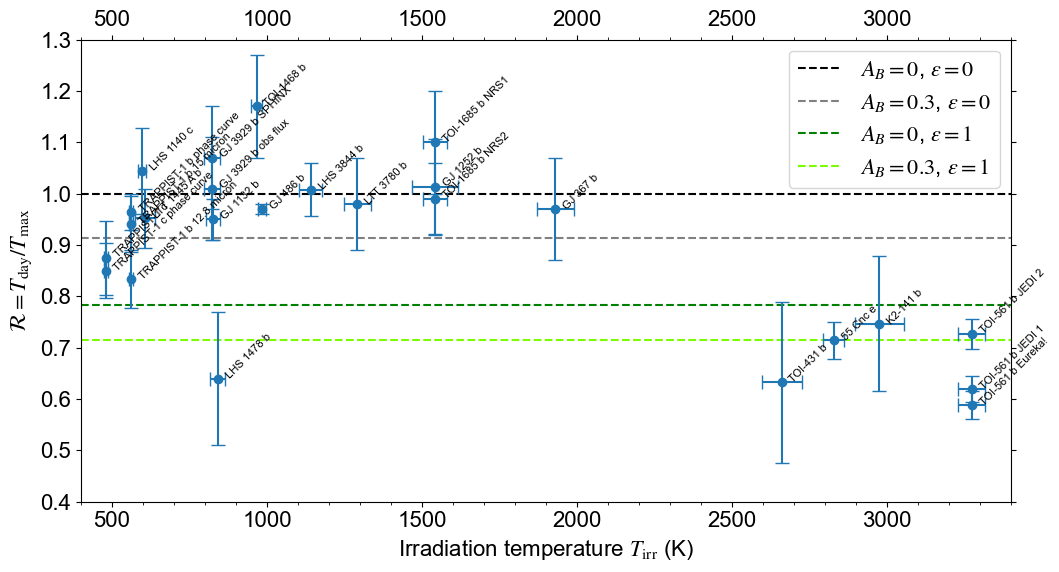

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# plot R under some specific cases: 0 Ab and no redistribution, Earth-like 0.3 Ab, and full redistribution
ax.axhline(1.0, color='k', linestyle='--', label=r"$A_B=0$, $\epsilon=0$")
ax.axhline(calcR(0.3, 0), color='#808080', linestyle='--', label=r"$A_B=0.3$, $\epsilon=0$")
ax.axhline(calcR(0, 1.0), color='g', linestyle='--', label=r"$A_B=0$, $\epsilon=1$")
ax.axhline(calcR(0.3, 1.0), color='#7CFC00', linestyle='--', label=r"$A_B=0.3$, $\epsilon=1$")

# plot the measured R of exoplanets
ax.errorbar(data_ori["T0_calculated"], data_ori["R_factor"], 
            xerr=data_ori["T0_calculated_err"],
            yerr=(-data_ori["R_factor_err2"], data_ori["R_factor_err1"]),
            linestyle='', marker="o", capsize=5)

# annotate planet name
for i in range(len(data_ori["pl_name"])):
    ax.annotate(data_ori["pl_name"][i], (data_ori["T0_calculated"][i]+20, data_ori["R_factor"][i]), 
                rotation=45, fontsize=8)

ax.set_xlabel(r"Irradiation temperature $T_{\rm irr}$ (K)", fontsize=16)
ax.set_ylabel(r"$\mathcal{R} = T_{\rm day} / T_{\rm max}$", fontsize=16)
ax.set_xlim([400, 3400])
ax.set_ylim([0.4, 1.3])
ax.xaxis.set_minor_locator(MultipleLocator(100.0))
ax.tick_params(axis='both', which='both', labelsize=16, top=True, right=True, labeltop=True)

plt.legend(fontsize=16)

plt.show()

## Define the separate datasets

These are subsets of data_ori above:

(1) Observed all rocky dataset (original papers reported values, exclude LHS 1478 b)

(2) Observed M-Earths dataset (original papers reported values, exclude LHS 1478 b)

(2.1) Observed K- and G-dwarf planets dataset

(3) Observed M-Earths subset (e.g., select only phase curves data for T-1 planets)

and thse should directly come from Coy et al. (2025) table:

(4) Coy et al. SPHNIX dataset

(5) Coy et al. PHOENIX dataset

Note that for the Coy et al. (2025) datasets, broadband vs spectral fitting (i.e., when there's spectral resolution using e.g., MIRI/LRS, instead of F1500W or F1280W which are wide filters without spectral resolution) will give different $\mathcal{R}$. Here, use just the broadband numbers. They also fitted to broadband data, while spectrally resolved data for e.g., GJ 367 b do not provide good fit to the positive slope.

In [9]:
data_allRocky = data_ori[data_ori['pl_name'] != 'LHS 1478 b'].copy().reset_index(drop=True)

data_MEarths = data_allRocky[data_allRocky['T0_calculated'] < 2100].copy().reset_index(drop=True)

data_KGEarths = data_allRocky[data_allRocky['T0_calculated'] >= 2100].copy().reset_index(drop=True)

In [10]:
target_list = ['GJ 1132 b', 'GJ 1252 b', 'GJ 367 b', 'GJ 486 b', 'LHS 1478 b', 'LHS 3844 b', 'LTT 1445 A b', 
               'TOI-1468 b', 'TOI-1685 b NRS1', 'TOI-1685 b NRS2', 'LHS 1140 c', 'LTT 3780 b', 'GJ 3929 b SPHINX',
               'TRAPPIST-1 b phase curve', 'TRAPPIST-1 c phase curve']
data_MEarths_subset = data_MEarths[data_MEarths['pl_name'].isin(target_list)].copy().reset_index(drop=True)

In [11]:
# subscript "coy" stands for data from Coy et al. (2025), Table 2
data_coy = pd.read_csv("Coy_et_al_2025_Table2.csv")
print(data_coy)

        pl_name  T0_calculated  T0_calculated_err  R_SPHINX  R_SPHINX_err1  \
0  TRAPPIST-1 c            480                  5     0.877          0.073   
1  TRAPPIST-1 b            562                  5     0.910          0.037   
2  LTT 1445 A b            600                 30     0.950          0.063   
3     GJ 1132 b            826                 14     0.940          0.043   
4      GJ 486 b            985                 10     0.973          0.016   
5    LHS 3844 b           1138                 28     0.996          0.033   
6     GJ 1252 b           1540                 98     1.067          0.094   
7    TOI-1685 b           1541                 40     1.066          0.080   
8      GJ 367 b           1930                 45     1.074          0.047   

   R_SPHINX_err2  R_PHOENIX  R_PHOENIX_err1  R_PHOENIX_err2  
0         -0.075      0.903           0.075          -0.082  
1         -0.036      0.933           0.039          -0.040  
2         -0.071      0.955      

## Plot the separate datasets to see if they are categorized as expected
### (1) All observed rocky planets
Exclude LHS 1478 b.

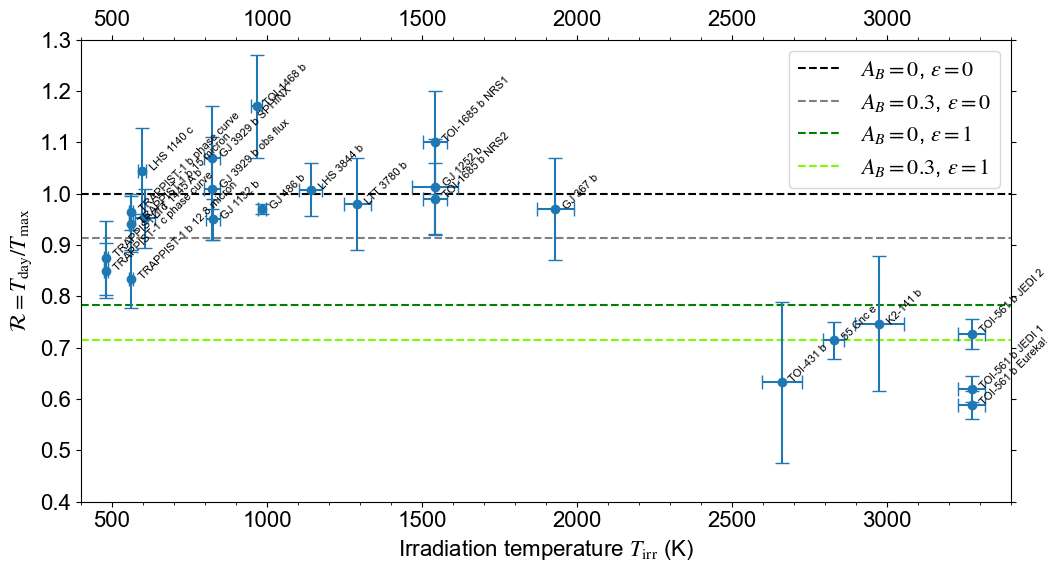

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# plot R under some specific cases: 0 Ab and no redistribution, Earth-like 0.3 Ab, and full redistribution
ax.axhline(1.0, color='k', linestyle='--', label=r"$A_B=0$, $\epsilon=0$")
ax.axhline(calcR(0.3, 0), color='#808080', linestyle='--', label=r"$A_B=0.3$, $\epsilon=0$")
ax.axhline(calcR(0, 1.0), color='g', linestyle='--', label=r"$A_B=0$, $\epsilon=1$")
ax.axhline(calcR(0.3, 1.0), color='#7CFC00', linestyle='--', label=r"$A_B=0.3$, $\epsilon=1$")

# plot the measured R of exoplanets
ax.errorbar(data_allRocky["T0_calculated"], data_allRocky["R_factor"], 
            xerr=data_allRocky["T0_calculated_err"],
            yerr=(-data_allRocky["R_factor_err2"], data_allRocky["R_factor_err1"]),
            linestyle='', marker="o", capsize=5)

# annotate planet name
for i in range(len(data_allRocky["pl_name"])):
    ax.annotate(data_allRocky["pl_name"][i], (data_allRocky["T0_calculated"][i]+20, data_allRocky["R_factor"][i]), 
                rotation=45, fontsize=8)

ax.set_xlabel(r"Irradiation temperature $T_{\rm irr}$ (K)", fontsize=16)
ax.set_ylabel(r"$\mathcal{R} = T_{\rm day} / T_{\rm max}$", fontsize=16)
ax.set_xlim([400, 3400])
ax.set_ylim([0.4, 1.3])
ax.xaxis.set_minor_locator(MultipleLocator(100.0))
ax.tick_params(axis='both', which='both', labelsize=16, top=True, right=True, labeltop=True)

plt.legend(fontsize=16)

plt.show()

### (2) All observed M-Earths
Like above, exclude LHS 1478 b.

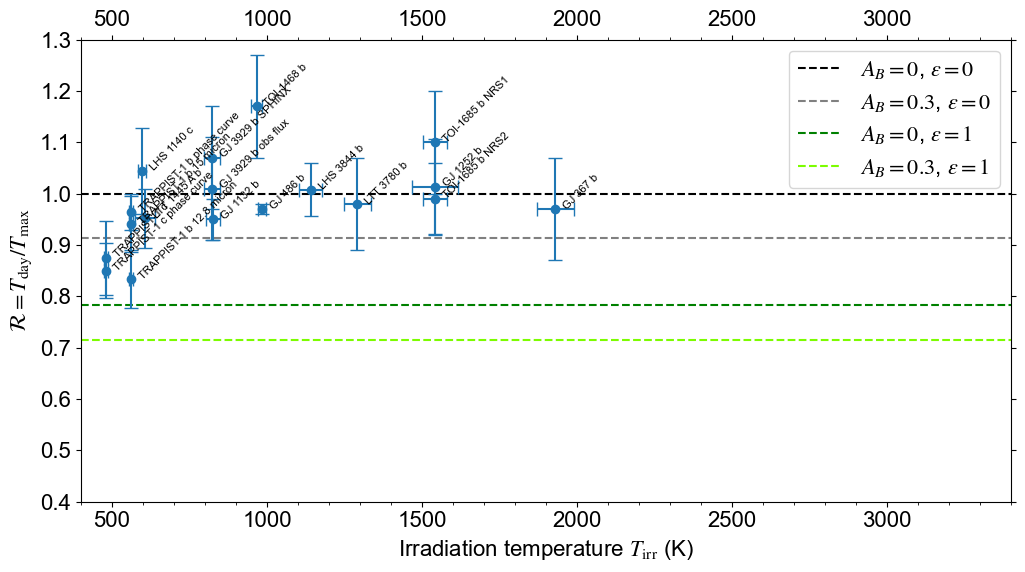

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# plot R under some specific cases: 0 Ab and no redistribution, Earth-like 0.3 Ab, and full redistribution
ax.axhline(1.0, color='k', linestyle='--', label=r"$A_B=0$, $\epsilon=0$")
ax.axhline(calcR(0.3, 0), color='#808080', linestyle='--', label=r"$A_B=0.3$, $\epsilon=0$")
ax.axhline(calcR(0, 1.0), color='g', linestyle='--', label=r"$A_B=0$, $\epsilon=1$")
ax.axhline(calcR(0.3, 1.0), color='#7CFC00', linestyle='--', label=r"$A_B=0.3$, $\epsilon=1$")

# plot the measured R of exoplanets
ax.errorbar(data_MEarths["T0_calculated"], data_MEarths["R_factor"], 
            xerr=data_MEarths["T0_calculated_err"],
            yerr=(-data_MEarths["R_factor_err2"], data_MEarths["R_factor_err1"]),
            linestyle='', marker="o", capsize=5)

# annotate planet name
for i in range(len(data_MEarths["pl_name"])):
    ax.annotate(data_MEarths["pl_name"][i], (data_MEarths["T0_calculated"][i]+20, data_MEarths["R_factor"][i]), 
                rotation=45, fontsize=8)

ax.set_xlabel(r"Irradiation temperature $T_{\rm irr}$ (K)", fontsize=16)
ax.set_ylabel(r"$\mathcal{R} = T_{\rm day} / T_{\rm max}$", fontsize=16)
ax.set_xlim([400, 3400])
ax.set_ylim([0.4, 1.3])
ax.xaxis.set_minor_locator(MultipleLocator(100.0))
ax.tick_params(axis='both', which='both', labelsize=16, top=True, right=True, labeltop=True)

plt.legend(fontsize=16)

plt.show()

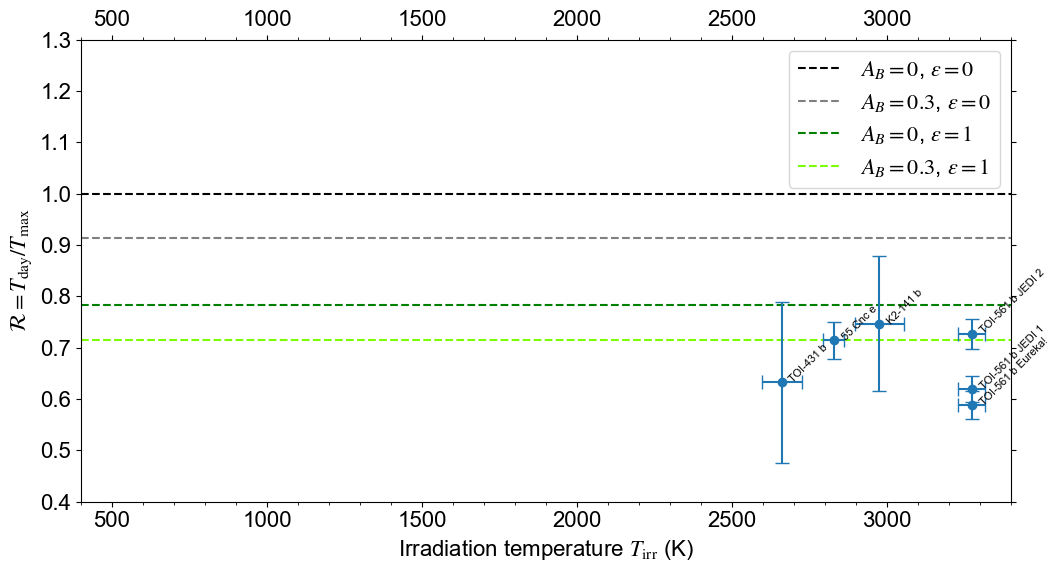

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# plot R under some specific cases: 0 Ab and no redistribution, Earth-like 0.3 Ab, and full redistribution
ax.axhline(1.0, color='k', linestyle='--', label=r"$A_B=0$, $\epsilon=0$")
ax.axhline(calcR(0.3, 0), color='#808080', linestyle='--', label=r"$A_B=0.3$, $\epsilon=0$")
ax.axhline(calcR(0, 1.0), color='g', linestyle='--', label=r"$A_B=0$, $\epsilon=1$")
ax.axhline(calcR(0.3, 1.0), color='#7CFC00', linestyle='--', label=r"$A_B=0.3$, $\epsilon=1$")

# plot the measured R of exoplanets
ax.errorbar(data_KGEarths["T0_calculated"], data_KGEarths["R_factor"], 
            xerr=data_KGEarths["T0_calculated_err"],
            yerr=(-data_KGEarths["R_factor_err2"], data_KGEarths["R_factor_err1"]),
            linestyle='', marker="o", capsize=5)

# annotate planet name
for i in range(len(data_KGEarths["pl_name"])):
    ax.annotate(data_KGEarths["pl_name"][i], (data_KGEarths["T0_calculated"][i]+20, data_KGEarths["R_factor"][i]), 
                rotation=45, fontsize=8)

ax.set_xlabel(r"Irradiation temperature $T_{\rm irr}$ (K)", fontsize=16)
ax.set_ylabel(r"$\mathcal{R} = T_{\rm day} / T_{\rm max}$", fontsize=16)
ax.set_xlim([400, 3400])
ax.set_ylim([0.4, 1.3])
ax.xaxis.set_minor_locator(MultipleLocator(100.0))
ax.tick_params(axis='both', which='both', labelsize=16, top=True, right=True, labeltop=True)

plt.legend(fontsize=16)

plt.show()

### (3) Subset of observed M-Earths

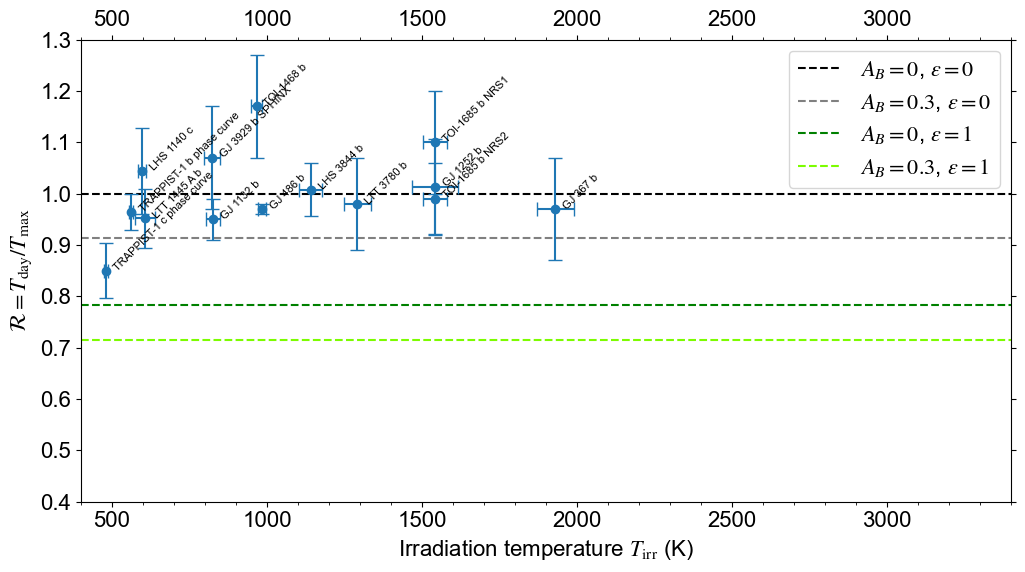

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# plot R under some specific cases: 0 Ab and no redistribution, Earth-like 0.3 Ab, and full redistribution
ax.axhline(1.0, color='k', linestyle='--', label=r"$A_B=0$, $\epsilon=0$")
ax.axhline(calcR(0.3, 0), color='#808080', linestyle='--', label=r"$A_B=0.3$, $\epsilon=0$")
ax.axhline(calcR(0, 1.0), color='g', linestyle='--', label=r"$A_B=0$, $\epsilon=1$")
ax.axhline(calcR(0.3, 1.0), color='#7CFC00', linestyle='--', label=r"$A_B=0.3$, $\epsilon=1$")

# plot the measured R of exoplanets
ax.errorbar(data_MEarths_subset["T0_calculated"], data_MEarths_subset["R_factor"], 
            xerr=data_MEarths_subset["T0_calculated_err"],
            yerr=(-data_MEarths_subset["R_factor_err2"], data_MEarths_subset["R_factor_err1"]),
            linestyle='', marker="o", capsize=5)

# annotate planet name
for i in range(len(data_MEarths_subset["pl_name"])):
    ax.annotate(data_MEarths_subset["pl_name"][i], (data_MEarths_subset["T0_calculated"][i]+20, data_MEarths_subset["R_factor"][i]), 
                rotation=45, fontsize=8)

ax.set_xlabel(r"Irradiation temperature $T_{\rm irr}$ (K)", fontsize=16)
ax.set_ylabel(r"$\mathcal{R} = T_{\rm day} / T_{\rm max}$", fontsize=16)
ax.set_xlim([400, 3400])
ax.set_ylim([0.4, 1.3])
ax.xaxis.set_minor_locator(MultipleLocator(100.0))
ax.tick_params(axis='both', which='both', labelsize=16, top=True, right=True, labeltop=True)

plt.legend(fontsize=16)

plt.show()

### (4) Coy+2025 SPHINX dataset

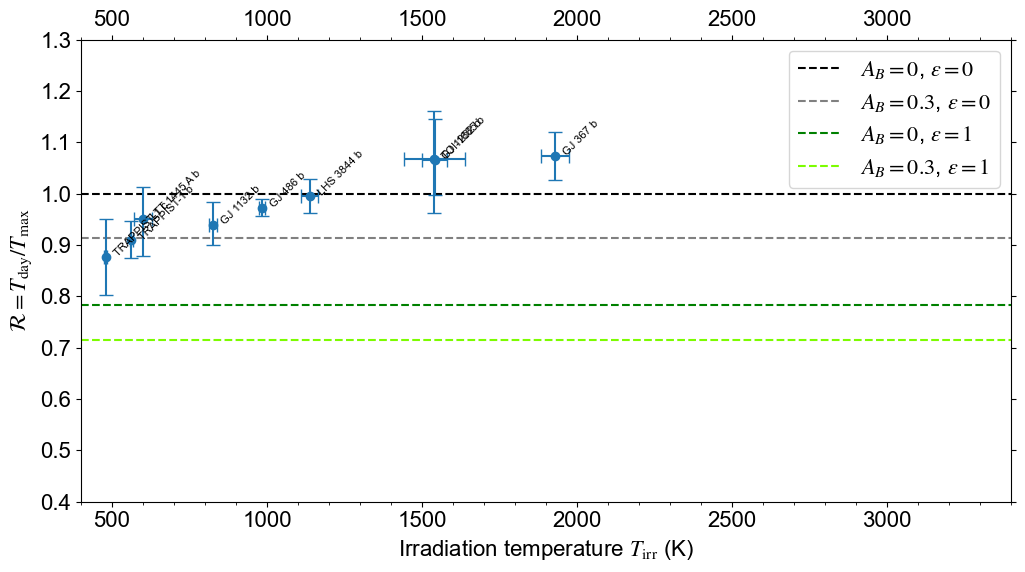

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# plot R under some specific cases: 0 Ab and no redistribution, Earth-like 0.3 Ab, and full redistribution
ax.axhline(1.0, color='k', linestyle='--', label=r"$A_B=0$, $\epsilon=0$")
ax.axhline(calcR(0.3, 0), color='#808080', linestyle='--', label=r"$A_B=0.3$, $\epsilon=0$")
ax.axhline(calcR(0, 1.0), color='g', linestyle='--', label=r"$A_B=0$, $\epsilon=1$")
ax.axhline(calcR(0.3, 1.0), color='#7CFC00', linestyle='--', label=r"$A_B=0.3$, $\epsilon=1$")

# plot the measured R of exoplanets
ax.errorbar(data_coy["T0_calculated"], data_coy["R_SPHINX"], 
            xerr=data_coy["T0_calculated_err"],
            yerr=(-data_coy["R_SPHINX_err2"], data_coy["R_SPHINX_err1"]),
            linestyle='', marker="o", capsize=5)

# annotate planet name
for i in range(len(data_coy["pl_name"])):
    ax.annotate(data_coy["pl_name"][i], (data_coy["T0_calculated"][i]+20, data_coy["R_SPHINX"][i]), 
                rotation=45, fontsize=8)

ax.set_xlabel(r"Irradiation temperature $T_{\rm irr}$ (K)", fontsize=16)
ax.set_ylabel(r"$\mathcal{R} = T_{\rm day} / T_{\rm max}$", fontsize=16)
ax.set_xlim([400, 3400])
ax.set_ylim([0.4, 1.3])
ax.xaxis.set_minor_locator(MultipleLocator(100.0))
ax.tick_params(axis='both', which='both', labelsize=16, top=True, right=True, labeltop=True)

plt.legend(fontsize=16)

plt.show()

### (5) Coy+2025 PHOENIX dataset

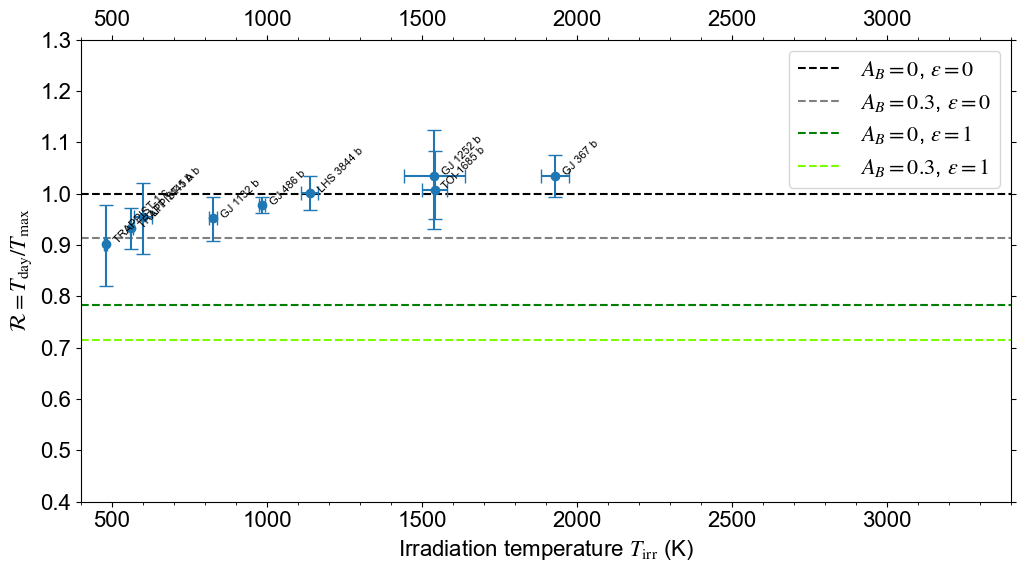

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# plot R under some specific cases: 0 Ab and no redistribution, Earth-like 0.3 Ab, and full redistribution
ax.axhline(1.0, color='k', linestyle='--', label=r"$A_B=0$, $\epsilon=0$")
ax.axhline(calcR(0.3, 0), color='#808080', linestyle='--', label=r"$A_B=0.3$, $\epsilon=0$")
ax.axhline(calcR(0, 1.0), color='g', linestyle='--', label=r"$A_B=0$, $\epsilon=1$")
ax.axhline(calcR(0.3, 1.0), color='#7CFC00', linestyle='--', label=r"$A_B=0.3$, $\epsilon=1$")

# plot the measured R of exoplanets
ax.errorbar(data_coy["T0_calculated"], data_coy["R_PHOENIX"], 
            xerr=data_coy["T0_calculated_err"],
            yerr=(-data_coy["R_PHOENIX_err2"], data_coy["R_PHOENIX_err1"]),
            linestyle='', marker="o", capsize=5)

# annotate planet name
for i in range(len(data_coy["pl_name"])):
    ax.annotate(data_coy["pl_name"][i], (data_coy["T0_calculated"][i]+20, data_coy["R_PHOENIX"][i]), 
                rotation=45, fontsize=8)

ax.set_xlabel(r"Irradiation temperature $T_{\rm irr}$ (K)", fontsize=16)
ax.set_ylabel(r"$\mathcal{R} = T_{\rm day} / T_{\rm max}$", fontsize=16)
ax.set_xlim([400, 3400])
ax.set_ylim([0.4, 1.3])
ax.xaxis.set_minor_locator(MultipleLocator(100.0))
ax.tick_params(axis='both', which='both', labelsize=16, top=True, right=True, labeltop=True)

plt.legend(fontsize=16)

plt.show()

# (2) Implement fitting functions
Includes (1) linear fit and (2) broken power law (BPL) fit. Both use scipy.odr for optimization.
## (2-1) Implement $\chi^2$ test function
Which quantifies the goodness of each fit below.

In [18]:
def compute_reduced_chi2(x, y, yerr, mean_y=None, linear_model=None, linear_params=None,
                         bpl_model=None, bpl_params=None, null_model=None):
    """
    Compute reduced chi² for null (flat), linear, and broken power law fits.

    Parameters
    ----------
    x, y : array_like
        Data points
    yerr : array_like
        1-sigma uncertainties in y
    mean_y : float, optional
        Mean value for the null hypothesis. If None, computed from y
    linear_model : callable, optional
        Function linear_model(x, *params)
    linear_params : array_like, optional
        Fitted parameters for the linear model
    bpl_model : callable, optional
        Broken power law function, signature: bpl_model(x, *params)
    bpl_params : array_like, optional
        Fitted parameters for broken power law

    Returns
    -------
    chi2_dict : dict
        Dictionary containing reduced chi² and dof for each model
        Keys: 'null', 'linear', 'broken_power_law'
    """
    x = np.asarray(x)
    y = np.asarray(y)
    yerr = np.asarray(yerr)

    N = len(y)

    if mean_y is None:
        mean_y = np.mean(y)
        
    if null_model is None:
        # Null hypothesis (flat line)
        chi2_null = np.sum(((y - mean_y)/yerr)**2)
        dof_null = N - 1
        red_chi2_null = chi2_null / dof_null
    else:
        y_null = null_model(x)
        chi2_null = np.sum(((y - y_null)/yerr)**2)
        dof_null = N - 1
        red_chi2_null = chi2_null / dof_null
    
    # Linear model
    if linear_model is not None and linear_params is not None:
        y_linear = linear_model(linear_params, x)
        chi2_linear = np.sum(((y - y_linear)/yerr)**2)
        dof_linear = N - len(linear_params)
        red_chi2_linear = chi2_linear / dof_linear
    else:
        dof_linear = None
        red_chi2_linear = None

    # Broken power law
    if bpl_model is not None and bpl_params is not None:
        y_bpl = bpl_model(bpl_params, x)
        chi2_bpl = np.sum(((y - y_bpl)/yerr)**2)
        dof_bpl = N - len(bpl_params)
        red_chi2_bpl = chi2_bpl / dof_bpl
    else:
        dof_bpl = None
        red_chi2_bpl = None

    return {
        'null': {'reduced_chi2': red_chi2_null, 'dof': dof_null},
        'linear': {'reduced_chi2': red_chi2_linear, 'dof': dof_linear},
        'broken_power_law': {'reduced_chi2': red_chi2_bpl, 'dof': dof_bpl}
    }

## (2-2) Implement linear (ODR) fit

In [19]:
def linear_func(B, x):
    return B[0] * x + B[1]


def fit_linear_odr(Tirr, R, Tirr_err, R_err):
    # first fit involving all planets
    model = Model(linear_func)
    input_data = RealData(Tirr, R, sx=Tirr_err, sy=R_err)
    odr = ODR(input_data, model, beta0=[1., 0.])
    output = odr.run()
    
    slope, intercept = output.beta
    slope_err, intercept_err = output.sd_beta

    t_stat = slope / slope_err
    dof = len(Tirr) - 2
    p_value = 2 * (1 - t.cdf(abs(t_stat), dof))
    return output, slope, intercept, slope_err, intercept_err, p_value


def fit_linear_odr_interval(x_fit, output):
    J = np.array([x_fit, np.ones_like(x_fit)]).T
    cov = output.cov_beta
    y_fit_err = np.sqrt(np.sum((J @ cov) * J, axis=1))
    return y_fit_err

### Test on Coy+25 SPHINX dataset (also test $\chi^2$ analysis)

{'null': {'reduced_chi2': 1.7101323123694945, 'dof': 8}, 'linear': {'reduced_chi2': 0.11266963307858949, 'dof': 7}, 'broken_power_law': {'reduced_chi2': None, 'dof': None}}


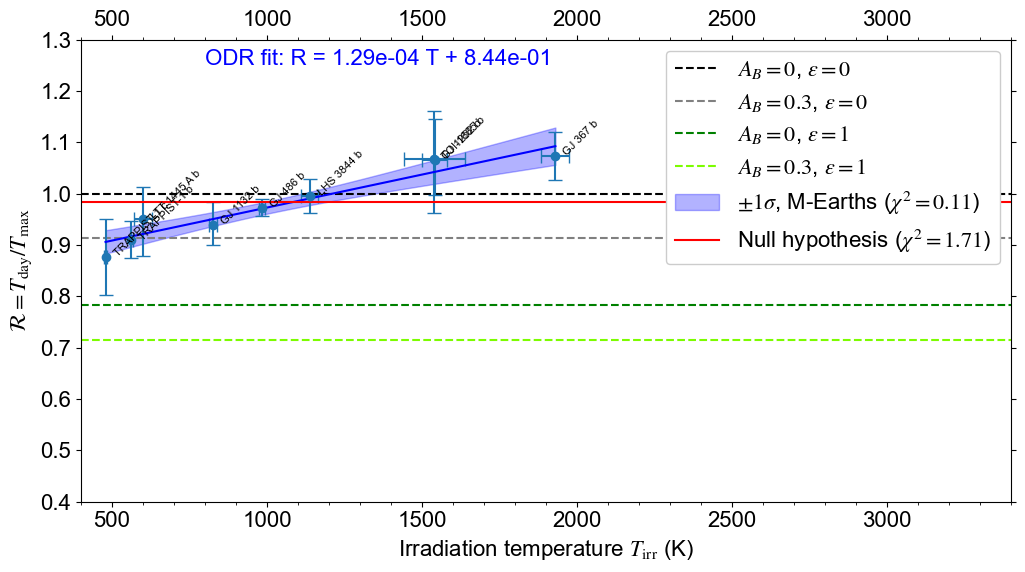

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# plot R under some specific cases: 0 Ab and no redistribution, Earth-like 0.3 Ab, and full redistribution
ax.axhline(1.0, color='k', linestyle='--', label=r"$A_B=0$, $\epsilon=0$")
ax.axhline(calcR(0.3, 0), color='#808080', linestyle='--', label=r"$A_B=0.3$, $\epsilon=0$")
ax.axhline(calcR(0, 1.0), color='g', linestyle='--', label=r"$A_B=0$, $\epsilon=1$")
ax.axhline(calcR(0.3, 1.0), color='#7CFC00', linestyle='--', label=r"$A_B=0.3$, $\epsilon=1$")

# plot the measured R of exoplanets
ax.errorbar(data_coy["T0_calculated"], data_coy["R_SPHINX"], 
            xerr=data_coy["T0_calculated_err"],
            yerr=(-data_coy["R_SPHINX_err2"], data_coy["R_SPHINX_err1"]),
            linestyle='', marker="o", capsize=5)

# annotate planet name
for i in range(len(data_coy["pl_name"])):
    ax.annotate(data_coy["pl_name"][i], (data_coy["T0_calculated"][i]+20, data_coy["R_SPHINX"][i]), 
                rotation=45, fontsize=8)

# fit linear trend
output, slope, intercept, slope_err, intercept_err, p_value = \
    fit_linear_odr(data_coy["T0_calculated"], data_coy["R_SPHINX"], 
                   data_coy["T0_calculated_err"], (data_coy["R_SPHINX_err1"]-data_coy["R_SPHINX_err2"])/2)

x_fit = np.linspace(min(data_coy["T0_calculated"])-0.5, max(data_coy["T0_calculated"])+0.5, 500)
y_fit = linear_func([slope, intercept], x_fit)
y_fit_err = fit_linear_odr_interval(x_fit, output)

# perform chi2 analysis
chi2_res = compute_reduced_chi2(data_coy["T0_calculated"], data_coy["R_SPHINX"], 
                                (data_coy["R_SPHINX_err1"]-data_coy["R_SPHINX_err2"])/2,
                                linear_model=linear_func,
                                linear_params=[slope, intercept])
print(chi2_res)

# plot the fitted linear trend
ax.plot(x_fit, y_fit, 'b-')
ax.annotate(f'ODR fit: R = {slope:.2e} T + {intercept:.2e}',
            (800.0, 1.25), color='b', fontsize=16)
ax.fill_between(x_fit, y_fit - y_fit_err, y_fit + y_fit_err, color='b', alpha=0.3, 
                label=r'$\pm1\sigma$, M-Earths ($\chi^2={%.2f}$)' % chi2_res["linear"]["reduced_chi2"])

# plot the null hypothesis
ax.axhline(np.mean(data_coy["R_SPHINX"]), color="r", 
           label=r"Null hypothesis ($\chi^2={%.2f}$)" % chi2_res["null"]["reduced_chi2"])

ax.set_xlabel(r"Irradiation temperature $T_{\rm irr}$ (K)", fontsize=16)
ax.set_ylabel(r"$\mathcal{R} = T_{\rm day} / T_{\rm max}$", fontsize=16)
ax.set_xlim([400, 3400])
ax.set_ylim([0.4, 1.3])
# ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(100.0))
ax.tick_params(axis='both', which='both', labelsize=16, top=True, right=True, labeltop=True)

plt.legend(fontsize=16, fancybox=True, framealpha=1, loc="upper right")

plt.show()

The true values from Coy+2025 are R = 0.000130 T + 0.8431, so very close (they didn't use ODR, but regular linear fit, I think; needs to confirm).

Note that for $\chi^2$ fits: 

| reduced $\chi^2$ | Interpretation                                                                                 |
| ------ | ---------------------------------------------------------------------------------------------- |
| ~ 1    | **Good fit**: the model explains the data within the expected uncertainties.                   |
| < 1    | Overfitting or overestimated errors: residuals smaller than expected.                          |
| > 1    | Underfitting or underestimated errors: model does not explain data fully, or errors too small. |
| ≫ 1    | Poor fit: the model is inadequate or errors are much too small.                                |

So the linear fit from Coy+2025 is actually overfitting... A bit concerning.

## (2-3) Implement broken power law fit

In [21]:
# Model definition for BPL for ODR fit
def broken_power_law(beta, x):
    A, xb, a1, a2 = beta
    return np.where(x <= xb, A * (x / xb)**(-a1), A * (x / xb)**(-a2))


def broken_power_law_odr(x, y, xerr, yerr, p0=None, maxit=1000):
    """
    Fit a two-segment broken power law using Orthogonal Distance Regression (ODR).

    Model:
        y = A * (x / xb)^(-alpha1)  for x <= xb
        y = A * (x / xb)^(-alpha2)  for x > xb

    Parameters
    ----------
    x, y : array_like
        Data points.
    xerr, yerr : array_like
        1-sigma uncertainties in x and y.
    p0 : list or tuple, optional
        Initial guess [A, xb, alpha1, alpha2].
        If None, estimated from data.
    maxit : int
        Maximum number of ODR iterations.

    Returns
    -------
    result : dict
        Dictionary with keys:
        - 'A', 'xb', 'alpha1', 'alpha2' : fitted parameters
        - 'A_err', 'xb_err', 'alpha1_err', 'alpha2_err' : 1-sigma uncertainties
        - 'cov' : parameter covariance matrix
        - 'res_var' : residual variance
        - 'beta' : parameter vector [A, xb, alpha1, alpha2]
        - 'y_model' : best-fit y values evaluated on x
    """
    # --- Prepare data ---
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    xerr = np.asarray(xerr, dtype=float)
    yerr = np.asarray(yerr, dtype=float)

    # --- Initial guess ---
    if p0 is None:
        A0 = np.median(y)
        xb0 = np.median(x)
        alpha1_0, alpha2_0 = 1.0, 2.0
        p0 = [A0, xb0, alpha1_0, alpha2_0]

    # --- Construct ODR objects ---
    model = Model(broken_power_law)
    data = RealData(x, y, sx=xerr, sy=yerr)
    odr_obj = ODR(data, model, beta0=p0, maxit=maxit)
    out = odr_obj.run()

    # --- Collect results ---
    popt = out.beta
    perr = out.sd_beta
    cov = out.cov_beta * out.res_var  # covariance matrix scaled by residual variance

    result = {
        'A': popt[0], 'xb': popt[1], 'alpha1': popt[2], 'alpha2': popt[3],
        'A_err': perr[0], 'xb_err': perr[1], 'alpha1_err': perr[2], 'alpha2_err': perr[3],
        'cov': cov,
        'res_var': out.res_var,
        'beta': popt,
        'y_model': broken_power_law(popt, x)
    }
    return result

### Test on all M-Earths (also test $\chi^2$ analysis)

{'null': {'reduced_chi2': 1.5033639182128238, 'dof': 17}, 'linear': {'reduced_chi2': None, 'dof': None}, 'broken_power_law': {'reduced_chi2': 1.0145263671917308, 'dof': 14}}


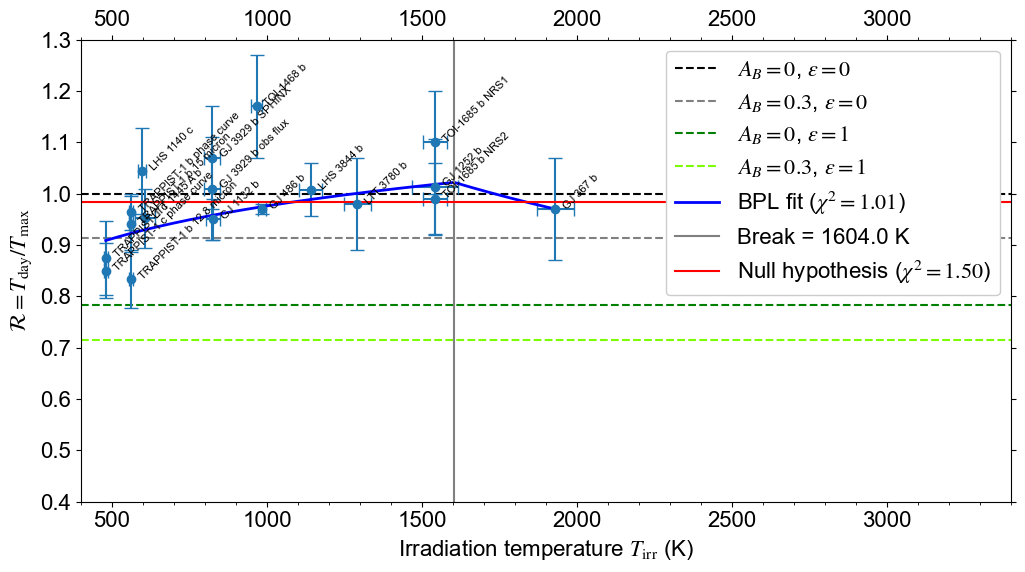

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# plot R under some specific cases: 0 Ab and no redistribution, Earth-like 0.3 Ab, and full redistribution
ax.axhline(1.0, color='k', linestyle='--', label=r"$A_B=0$, $\epsilon=0$")
ax.axhline(calcR(0.3, 0), color='#808080', linestyle='--', label=r"$A_B=0.3$, $\epsilon=0$")
ax.axhline(calcR(0, 1.0), color='g', linestyle='--', label=r"$A_B=0$, $\epsilon=1$")
ax.axhline(calcR(0.3, 1.0), color='#7CFC00', linestyle='--', label=r"$A_B=0.3$, $\epsilon=1$")

# plot the measured R of exoplanets
ax.errorbar(data_MEarths["T0_calculated"], data_MEarths["R_factor"], 
            xerr=data_MEarths["T0_calculated_err"],
            yerr=(-data_MEarths["R_factor_err2"], data_MEarths["R_factor_err1"]),
            linestyle='', marker="o", capsize=5)

# annotate planet name
for i in range(len(data_MEarths["pl_name"])):
    ax.annotate(data_MEarths["pl_name"][i], (data_MEarths["T0_calculated"][i]+20, data_MEarths["R_factor"][i]), 
                rotation=45, fontsize=8)

# perform broken power law fits
results = broken_power_law_odr(data_MEarths["T0_calculated"], data_MEarths["R_factor"],
                               data_MEarths["T0_calculated_err"],
                               (data_MEarths["R_factor_err1"]-data_MEarths["R_factor_err2"])/2)

# perform chi2 analysis
chi2_res = compute_reduced_chi2(data_MEarths["T0_calculated"], data_MEarths["R_factor"], 
                                (data_MEarths["R_factor_err1"]-data_MEarths["R_factor_err2"])/2,
                                bpl_model=broken_power_law,
                                bpl_params=results["beta"])
print(chi2_res)

# plot broken power law fit
x_fit = np.linspace(min(data_MEarths["T0_calculated"])-0.5, max(data_MEarths["T0_calculated"])+0.5, 500)
y_fit = broken_power_law(results["beta"], x_fit)
ax.plot(x_fit, y_fit, 'b-', lw=2, 
        label='BPL fit ($\chi^2={%.2f}$)' % chi2_res["broken_power_law"]["reduced_chi2"])
ax.axvline(results['xb'], color='gray', ls='-', label=f"Break = {results['xb']:.1f} K")

# plot the null hypothesis
ax.axhline(np.mean(data_MEarths["R_factor"]), color="r", 
           label=r"Null hypothesis ($\chi^2={%.2f}$)" % chi2_res["null"]["reduced_chi2"])

ax.set_xlabel(r"Irradiation temperature $T_{\rm irr}$ (K)", fontsize=16)
ax.set_ylabel(r"$\mathcal{R} = T_{\rm day} / T_{\rm max}$", fontsize=16)
ax.set_xlim([400, 3400])
ax.set_ylim([0.4, 1.3])
ax.xaxis.set_minor_locator(MultipleLocator(100.0))
ax.tick_params(axis='both', which='both', labelsize=16, top=True, right=True, labeltop=True)

plt.legend(fontsize=16, fancybox=True, framealpha=1, loc="upper right")

plt.show()

# (3) Perform fit for all datasets

## (3-1) All observed rocky exoplanets

{'null': {'reduced_chi2': 18.023707242534535, 'dof': 23}, 'linear': {'reduced_chi2': 2.9720483727777673, 'dof': 22}, 'broken_power_law': {'reduced_chi2': 1.4201619678975541, 'dof': 20}}
[ 1.03309802e+00  1.79023790e+03 -9.73419828e-02  7.96114526e-01]
0.9050416666666669


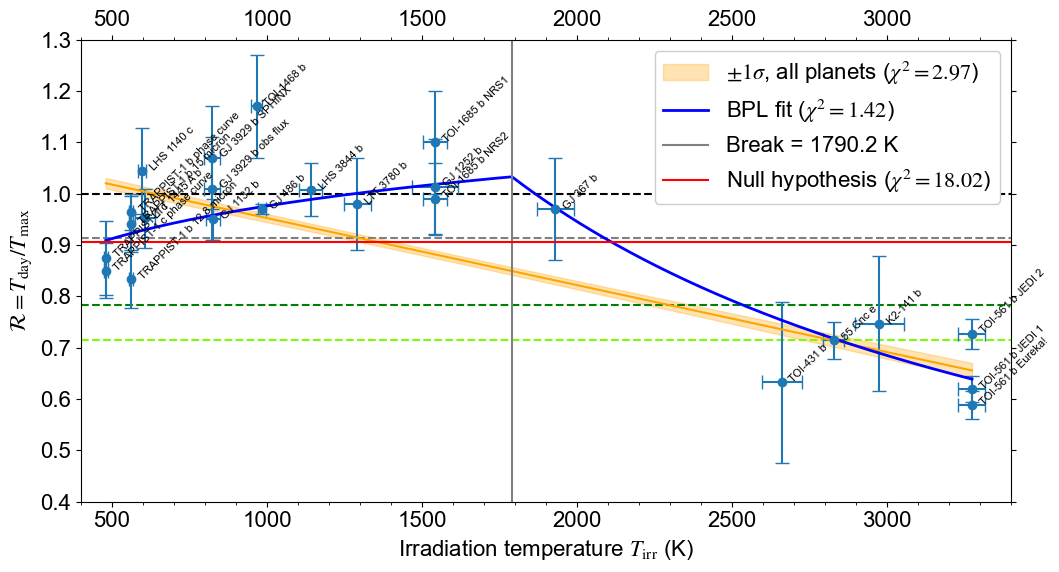

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# plot R under some specific cases: 0 Ab and no redistribution, Earth-like 0.3 Ab, and full redistribution
ax.axhline(1.0, color='k', linestyle='--') #, label=r"$A_B=0$, $\epsilon=0$")
ax.axhline(calcR(0.3, 0), color='#808080', linestyle='--') #, label=r"$A_B=0.3$, $\epsilon=0$")
ax.axhline(calcR(0, 1.0), color='g', linestyle='--') #, label=r"$A_B=0$, $\epsilon=1$")
ax.axhline(calcR(0.3, 1.0), color='#7CFC00', linestyle='--') #, label=r"$A_B=0.3$, $\epsilon=1$")

# plot the measured R of exoplanets
ax.errorbar(data_allRocky["T0_calculated"], data_allRocky["R_factor"], 
            xerr=data_allRocky["T0_calculated_err"],
            yerr=(-data_allRocky["R_factor_err2"], data_allRocky["R_factor_err1"]),
            linestyle='', marker="o", capsize=5)

# annotate planet name
for i in range(len(data_allRocky["pl_name"])):
    ax.annotate(data_allRocky["pl_name"][i], (data_allRocky["T0_calculated"][i]+20, data_allRocky["R_factor"][i]), 
                rotation=45, fontsize=8)

#======== Code block for fitting ==============================
# fit linear trend
output, slope, intercept, slope_err, intercept_err, p_value = \
    fit_linear_odr(data_allRocky["T0_calculated"], data_allRocky["R_factor"], 
                   data_allRocky["T0_calculated_err"], 
                   (data_allRocky["R_factor_err1"]-data_allRocky["R_factor_err2"])/2)

x_fit = np.linspace(min(data_allRocky["T0_calculated"])-0.5, max(data_allRocky["T0_calculated"])+0.5, 500)
y_fit = linear_func([slope, intercept], x_fit)
y_fit_err = fit_linear_odr_interval(x_fit, output)

# perform broken power law fits
bpl_res = broken_power_law_odr(data_allRocky["T0_calculated"], data_allRocky["R_factor"],
                               data_allRocky["T0_calculated_err"],
                               (data_allRocky["R_factor_err1"]-data_allRocky["R_factor_err2"])/2)

# perform chi2 analysis
chi2_res = compute_reduced_chi2(data_allRocky["T0_calculated"], data_allRocky["R_factor"], 
                                (data_allRocky["R_factor_err1"]-data_allRocky["R_factor_err2"])/2,
                                linear_model=linear_func,
                                linear_params=[slope, intercept],
                                bpl_model=broken_power_law,
                                bpl_params=bpl_res["beta"])
print(chi2_res)

# plot the fitted linear trend
ax.plot(x_fit, y_fit, color='orange')
ax.fill_between(x_fit, y_fit - y_fit_err, y_fit + y_fit_err, color='orange', alpha=0.3, 
                label=r'$\pm1\sigma$, all planets ($\chi^2={%.2f}$)' % chi2_res["linear"]["reduced_chi2"])

# plot broken power law fit
x_fit = np.linspace(min(data_allRocky["T0_calculated"])-0.5, max(data_allRocky["T0_calculated"])+0.5, 500)
y_fit = broken_power_law(bpl_res["beta"], x_fit)
ax.plot(x_fit, y_fit, 'b-', lw=2, 
        label='BPL fit ($\chi^2={%.2f}$)' % chi2_res["broken_power_law"]["reduced_chi2"])
ax.axvline(bpl_res['xb'], color='gray', ls='-', label=f"Break = {bpl_res['xb']:.1f} K")
print(bpl_res["beta"])

# plot the null hypothesis
ax.axhline(np.mean(data_allRocky["R_factor"]), color="r", 
           label=r"Null hypothesis ($\chi^2={%.2f}$)" % chi2_res["null"]["reduced_chi2"])
print(np.mean(data_allRocky["R_factor"]))
#===============================================================

ax.set_xlabel(r"Irradiation temperature $T_{\rm irr}$ (K)", fontsize=16)
ax.set_ylabel(r"$\mathcal{R} = T_{\rm day} / T_{\rm max}$", fontsize=16)
ax.set_xlim([400, 3400])
ax.set_ylim([0.4, 1.3])
ax.xaxis.set_minor_locator(MultipleLocator(100.0))
ax.tick_params(axis='both', which='both', labelsize=16, top=True, right=True, labeltop=True)

plt.legend(fontsize=16, fancybox=True, framealpha=1, loc="upper right")

# plt.savefig("RockyPlanetIR_Tirr_vs_R_ODR_BPL_fits.pdf", bbox_inches="tight")
# plt.savefig("RockyPlanetIR_Tirr_vs_R_ODR_BPL_fits.png", bbox_inches="tight", dpi=300)
plt.show()

## (3-2) All observed M-Earths

{'null': {'reduced_chi2': 1.5033639182128238, 'dof': 17}, 'linear': {'reduced_chi2': 0.9737848776468657, 'dof': 16}, 'broken_power_law': {'reduced_chi2': 1.0145263671917308, 'dof': 14}}
[ 1.02211017e+00  1.60398648e+03 -9.73419866e-02  2.82301085e-01]
0.9829444444444445


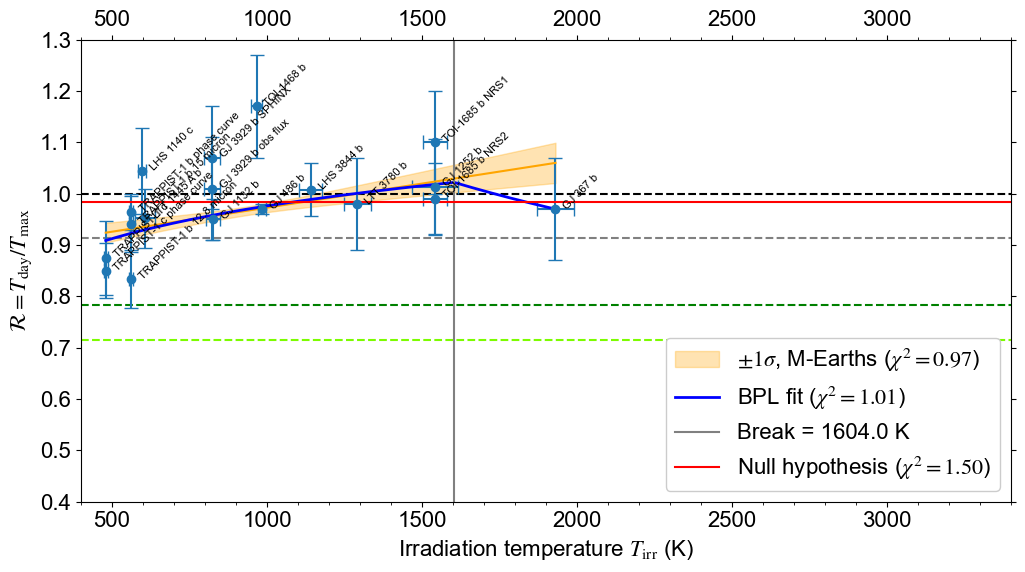

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# plot R under some specific cases: 0 Ab and no redistribution, Earth-like 0.3 Ab, and full redistribution
ax.axhline(1.0, color='k', linestyle='--') #, label=r"$A_B=0$, $\epsilon=0$")
ax.axhline(calcR(0.3, 0), color='#808080', linestyle='--') #, label=r"$A_B=0.3$, $\epsilon=0$")
ax.axhline(calcR(0, 1.0), color='g', linestyle='--') #, label=r"$A_B=0$, $\epsilon=1$")
ax.axhline(calcR(0.3, 1.0), color='#7CFC00', linestyle='--') #, label=r"$A_B=0.3$, $\epsilon=1$")

# plot the measured R of exoplanets
ax.errorbar(data_MEarths["T0_calculated"], data_MEarths["R_factor"], 
            xerr=data_MEarths["T0_calculated_err"],
            yerr=(-data_MEarths["R_factor_err2"], data_MEarths["R_factor_err1"]),
            linestyle='', marker="o", capsize=5)

# annotate planet name
for i in range(len(data_MEarths["pl_name"])):
    ax.annotate(data_MEarths["pl_name"][i], (data_MEarths["T0_calculated"][i]+20, data_MEarths["R_factor"][i]), 
                rotation=45, fontsize=8)

#======== Code block for fitting ==============================
# fit linear trend
output, slope, intercept, slope_err, intercept_err, p_value = \
    fit_linear_odr(data_MEarths["T0_calculated"], data_MEarths["R_factor"], 
                   data_MEarths["T0_calculated_err"], 
                   (data_MEarths["R_factor_err1"]-data_MEarths["R_factor_err2"])/2)

x_fit = np.linspace(min(data_MEarths["T0_calculated"])-0.5, max(data_MEarths["T0_calculated"])+0.5, 500)
y_fit = linear_func([slope, intercept], x_fit)
y_fit_err = fit_linear_odr_interval(x_fit, output)

# perform broken power law fits
bpl_res = broken_power_law_odr(data_MEarths["T0_calculated"], data_MEarths["R_factor"],
                               data_MEarths["T0_calculated_err"],
                               (data_MEarths["R_factor_err1"]-data_MEarths["R_factor_err2"])/2)

# perform chi2 analysis
chi2_res = compute_reduced_chi2(data_MEarths["T0_calculated"], data_MEarths["R_factor"], 
                                (data_MEarths["R_factor_err1"]-data_MEarths["R_factor_err2"])/2,
                                linear_model=linear_func,
                                linear_params=[slope, intercept],
                                bpl_model=broken_power_law,
                                bpl_params=bpl_res["beta"])
print(chi2_res)

# plot the fitted linear trend
ax.plot(x_fit, y_fit, color='orange')
ax.fill_between(x_fit, y_fit - y_fit_err, y_fit + y_fit_err, color='orange', alpha=0.3, 
                label=r'$\pm1\sigma$, M-Earths ($\chi^2={%.2f}$)' % chi2_res["linear"]["reduced_chi2"])

# plot broken power law fit
x_fit = np.linspace(min(data_MEarths["T0_calculated"])-0.5, max(data_MEarths["T0_calculated"])+0.5, 500)
y_fit = broken_power_law(bpl_res["beta"], x_fit)
ax.plot(x_fit, y_fit, 'b-', lw=2, 
        label='BPL fit ($\chi^2={%.2f}$)' % chi2_res["broken_power_law"]["reduced_chi2"])
ax.axvline(bpl_res['xb'], color='gray', ls='-', label=f"Break = {bpl_res['xb']:.1f} K")
print(bpl_res["beta"])

# plot the null hypothesis
ax.axhline(np.mean(data_MEarths["R_factor"]), color="r", 
           label=r"Null hypothesis ($\chi^2={%.2f}$)" % chi2_res["null"]["reduced_chi2"])
print(np.mean(data_MEarths["R_factor"]))
#===============================================================

ax.set_xlabel(r"Irradiation temperature $T_{\rm irr}$ (K)", fontsize=16)
ax.set_ylabel(r"$\mathcal{R} = T_{\rm day} / T_{\rm max}$", fontsize=16)
ax.set_xlim([400, 3400])
ax.set_ylim([0.4, 1.3])
ax.xaxis.set_minor_locator(MultipleLocator(100.0))
ax.tick_params(axis='both', which='both', labelsize=16, top=True, right=True, labeltop=True)

plt.legend(fontsize=16, fancybox=True, framealpha=1, loc="lower right")

plt.show()

{'null': {'reduced_chi2': 3.8891930274854927, 'dof': 5}, 'linear': {'reduced_chi2': 3.5680320953176423, 'dof': 4}, 'broken_power_law': {'reduced_chi2': None, 'dof': None}}
0.6713333333333334


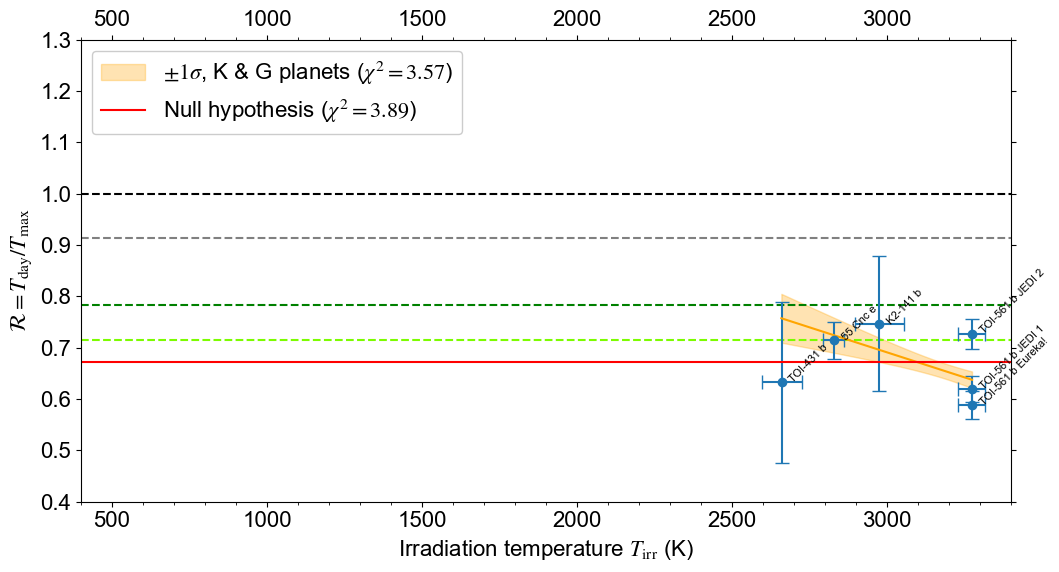

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# plot R under some specific cases: 0 Ab and no redistribution, Earth-like 0.3 Ab, and full redistribution
ax.axhline(1.0, color='k', linestyle='--') #, label=r"$A_B=0$, $\epsilon=0$")
ax.axhline(calcR(0.3, 0), color='#808080', linestyle='--') #, label=r"$A_B=0.3$, $\epsilon=0$")
ax.axhline(calcR(0, 1.0), color='g', linestyle='--') #, label=r"$A_B=0$, $\epsilon=1$")
ax.axhline(calcR(0.3, 1.0), color='#7CFC00', linestyle='--') #, label=r"$A_B=0.3$, $\epsilon=1$")

# plot the measured R of exoplanets
ax.errorbar(data_KGEarths["T0_calculated"], data_KGEarths["R_factor"], 
            xerr=data_KGEarths["T0_calculated_err"],
            yerr=(-data_KGEarths["R_factor_err2"], data_KGEarths["R_factor_err1"]),
            linestyle='', marker="o", capsize=5)

# annotate planet name
for i in range(len(data_KGEarths["pl_name"])):
    ax.annotate(data_KGEarths["pl_name"][i], (data_KGEarths["T0_calculated"][i]+20, data_KGEarths["R_factor"][i]), 
                rotation=45, fontsize=8)

#======== Code block for fitting ==============================
# fit linear trend
output, slope, intercept, slope_err, intercept_err, p_value = \
    fit_linear_odr(data_KGEarths["T0_calculated"], data_KGEarths["R_factor"], 
                   data_KGEarths["T0_calculated_err"], 
                   (data_KGEarths["R_factor_err1"]-data_KGEarths["R_factor_err2"])/2)

x_fit = np.linspace(min(data_KGEarths["T0_calculated"])-0.5, max(data_KGEarths["T0_calculated"])+0.5, 500)
y_fit = linear_func([slope, intercept], x_fit)
y_fit_err = fit_linear_odr_interval(x_fit, output)

# perform chi2 analysis
chi2_res = compute_reduced_chi2(data_KGEarths["T0_calculated"], data_KGEarths["R_factor"], 
                                (data_KGEarths["R_factor_err1"]-data_KGEarths["R_factor_err2"])/2,
                                linear_model=linear_func,
                                linear_params=[slope, intercept],
                                bpl_model=None,
                                bpl_params=None)
print(chi2_res)

# plot the fitted linear trend
ax.plot(x_fit, y_fit, color='orange')
ax.fill_between(x_fit, y_fit - y_fit_err, y_fit + y_fit_err, color='orange', alpha=0.3, 
                label=r'$\pm1\sigma$, K & G planets ($\chi^2={%.2f}$)' % chi2_res["linear"]["reduced_chi2"])

# plot the null hypothesis
ax.axhline(np.mean(data_KGEarths["R_factor"]), color="r", 
           label=r"Null hypothesis ($\chi^2={%.2f}$)" % chi2_res["null"]["reduced_chi2"])
print(np.mean(data_KGEarths["R_factor"]))
#===============================================================

ax.set_xlabel(r"Irradiation temperature $T_{\rm irr}$ (K)", fontsize=16)
ax.set_ylabel(r"$\mathcal{R} = T_{\rm day} / T_{\rm max}$", fontsize=16)
ax.set_xlim([400, 3400])
ax.set_ylim([0.4, 1.3])
ax.xaxis.set_minor_locator(MultipleLocator(100.0))
ax.tick_params(axis='both', which='both', labelsize=16, top=True, right=True, labeltop=True)

plt.legend(fontsize=16, fancybox=True, framealpha=1, loc="upper left")

plt.show()

## (3-3) Subset of observed M-Earths

{'null': {'reduced_chi2': 2.0638505604318027, 'dof': 13}, 'linear': {'reduced_chi2': 0.9382664171566047, 'dof': 12}, 'broken_power_law': {'reduced_chi2': 1.0684189443471432, 'dof': 10}}
[ 1.00938196e+00  1.58694529e+03 -7.23546090e-02  2.03015405e-01]
1.002357142857143


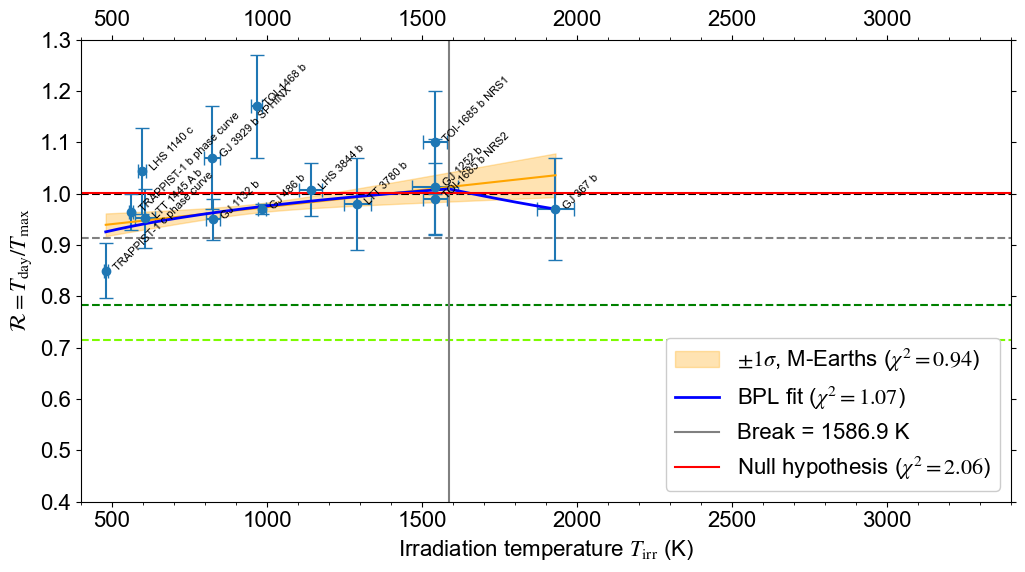

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# plot R under some specific cases: 0 Ab and no redistribution, Earth-like 0.3 Ab, and full redistribution
ax.axhline(1.0, color='k', linestyle='--') #, label=r"$A_B=0$, $\epsilon=0$")
ax.axhline(calcR(0.3, 0), color='#808080', linestyle='--') #, label=r"$A_B=0.3$, $\epsilon=0$")
ax.axhline(calcR(0, 1.0), color='g', linestyle='--') #, label=r"$A_B=0$, $\epsilon=1$")
ax.axhline(calcR(0.3, 1.0), color='#7CFC00', linestyle='--') #, label=r"$A_B=0.3$, $\epsilon=1$")

# plot the measured R of exoplanets
ax.errorbar(data_MEarths_subset["T0_calculated"], data_MEarths_subset["R_factor"], 
            xerr=data_MEarths_subset["T0_calculated_err"],
            yerr=(-data_MEarths_subset["R_factor_err2"], data_MEarths_subset["R_factor_err1"]),
            linestyle='', marker="o", capsize=5)

# annotate planet name
for i in range(len(data_MEarths_subset["pl_name"])):
    ax.annotate(data_MEarths_subset["pl_name"][i], (data_MEarths_subset["T0_calculated"][i]+20, data_MEarths_subset["R_factor"][i]), 
                rotation=45, fontsize=8)

#======== Code block for fitting ==============================
# fit linear trend
output, slope, intercept, slope_err, intercept_err, p_value = \
    fit_linear_odr(data_MEarths_subset["T0_calculated"], data_MEarths_subset["R_factor"], 
                   data_MEarths_subset["T0_calculated_err"], 
                   (data_MEarths_subset["R_factor_err1"]-data_MEarths_subset["R_factor_err2"])/2)

x_fit = np.linspace(min(data_MEarths_subset["T0_calculated"])-0.5, max(data_MEarths_subset["T0_calculated"])+0.5, 500)
y_fit = linear_func([slope, intercept], x_fit)
y_fit_err = fit_linear_odr_interval(x_fit, output)

# perform broken power law fits
bpl_res = broken_power_law_odr(data_MEarths_subset["T0_calculated"], data_MEarths_subset["R_factor"],
                               data_MEarths_subset["T0_calculated_err"],
                               (data_MEarths_subset["R_factor_err1"]-data_MEarths_subset["R_factor_err2"])/2)

# perform chi2 analysis
chi2_res = compute_reduced_chi2(data_MEarths_subset["T0_calculated"], data_MEarths_subset["R_factor"], 
                                (data_MEarths_subset["R_factor_err1"]-data_MEarths_subset["R_factor_err2"])/2,
                                linear_model=linear_func,
                                linear_params=[slope, intercept],
                                bpl_model=broken_power_law,
                                bpl_params=bpl_res["beta"])
print(chi2_res)

# plot the fitted linear trend
ax.plot(x_fit, y_fit, color='orange')
ax.fill_between(x_fit, y_fit - y_fit_err, y_fit + y_fit_err, color='orange', alpha=0.3, 
                label=r'$\pm1\sigma$, M-Earths ($\chi^2={%.2f}$)' % chi2_res["linear"]["reduced_chi2"])

# plot broken power law fit
x_fit = np.linspace(min(data_MEarths_subset["T0_calculated"])-0.5, max(data_MEarths_subset["T0_calculated"])+0.5, 500)
y_fit = broken_power_law(bpl_res["beta"], x_fit)
ax.plot(x_fit, y_fit, 'b-', lw=2, 
        label='BPL fit ($\chi^2={%.2f}$)' % chi2_res["broken_power_law"]["reduced_chi2"])
ax.axvline(bpl_res['xb'], color='gray', ls='-', label=f"Break = {bpl_res['xb']:.1f} K")
print(bpl_res["beta"])

# plot the null hypothesis
ax.axhline(np.mean(data_MEarths_subset["R_factor"]), color="r", 
           label=r"Null hypothesis ($\chi^2={%.2f}$)" % chi2_res["null"]["reduced_chi2"])
print(np.mean(data_MEarths_subset["R_factor"]))
#===============================================================

ax.set_xlabel(r"Irradiation temperature $T_{\rm irr}$ (K)", fontsize=16)
ax.set_ylabel(r"$\mathcal{R} = T_{\rm day} / T_{\rm max}$", fontsize=16)
ax.set_xlim([400, 3400])
ax.set_ylim([0.4, 1.3])
ax.xaxis.set_minor_locator(MultipleLocator(100.0))
ax.tick_params(axis='both', which='both', labelsize=16, top=True, right=True, labeltop=True)

plt.legend(fontsize=16, fancybox=True, framealpha=1, loc="lower right")

plt.show()

## (3-4) Coy+2025 SPHNIX dataset

{'null': {'reduced_chi2': 1.7101323123694945, 'dof': 8}, 'linear': {'reduced_chi2': 0.11266963307858949, 'dof': 7}, 'broken_power_law': {'reduced_chi2': 0.10133967856329262, 'dof': 5}}
[ 9.46395722e-01  8.25910004e+02 -9.83906429e-02 -1.58964882e-01]
0.9836666666666668


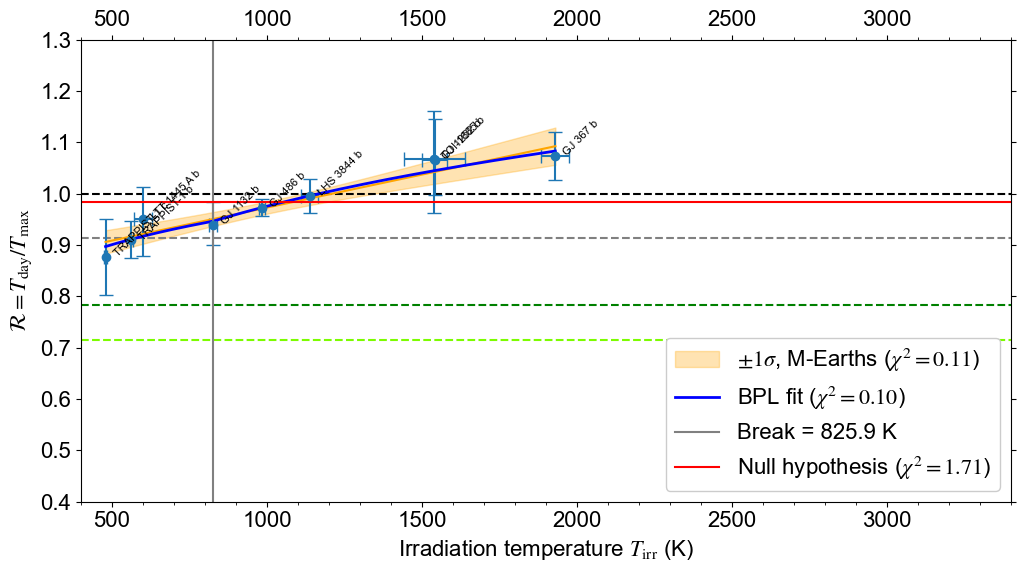

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# plot R under some specific cases: 0 Ab and no redistribution, Earth-like 0.3 Ab, and full redistribution
ax.axhline(1.0, color='k', linestyle='--') #, label=r"$A_B=0$, $\epsilon=0$")
ax.axhline(calcR(0.3, 0), color='#808080', linestyle='--') #, label=r"$A_B=0.3$, $\epsilon=0$")
ax.axhline(calcR(0, 1.0), color='g', linestyle='--') #, label=r"$A_B=0$, $\epsilon=1$")
ax.axhline(calcR(0.3, 1.0), color='#7CFC00', linestyle='--') #, label=r"$A_B=0.3$, $\epsilon=1$")

# plot the measured R of exoplanets
ax.errorbar(data_coy["T0_calculated"], data_coy["R_SPHINX"], 
            xerr=data_coy["T0_calculated_err"],
            yerr=(-data_coy["R_SPHINX_err2"], data_coy["R_SPHINX_err1"]),
            linestyle='', marker="o", capsize=5)

# annotate planet name
for i in range(len(data_coy["pl_name"])):
    ax.annotate(data_coy["pl_name"][i], (data_coy["T0_calculated"][i]+20, data_coy["R_SPHINX"][i]), 
                rotation=45, fontsize=8)

#======== Code block for fitting ==============================
# fit linear trend
output, slope, intercept, slope_err, intercept_err, p_value = \
    fit_linear_odr(data_coy["T0_calculated"], data_coy["R_SPHINX"], 
                   data_coy["T0_calculated_err"], 
                   (data_coy["R_SPHINX_err1"]-data_coy["R_SPHINX_err2"])/2)

x_fit = np.linspace(min(data_coy["T0_calculated"])-0.5, max(data_coy["T0_calculated"])+0.5, 500)
y_fit = linear_func([slope, intercept], x_fit)
y_fit_err = fit_linear_odr_interval(x_fit, output)

# perform broken power law fits
bpl_res = broken_power_law_odr(data_coy["T0_calculated"], data_coy["R_SPHINX"],
                               data_coy["T0_calculated_err"],
                               (data_coy["R_SPHINX_err1"]-data_coy["R_SPHINX_err2"])/2)

# perform chi2 analysis
chi2_res = compute_reduced_chi2(data_coy["T0_calculated"], data_coy["R_SPHINX"], 
                                (data_coy["R_SPHINX_err1"]-data_coy["R_SPHINX_err2"])/2,
                                linear_model=linear_func,
                                linear_params=[slope, intercept],
                                bpl_model=broken_power_law,
                                bpl_params=bpl_res["beta"])
print(chi2_res)

# plot the fitted linear trend
ax.plot(x_fit, y_fit, color='orange')
ax.fill_between(x_fit, y_fit - y_fit_err, y_fit + y_fit_err, color='orange', alpha=0.3, 
                label=r'$\pm1\sigma$, M-Earths ($\chi^2={%.2f}$)' % chi2_res["linear"]["reduced_chi2"])

# plot broken power law fit
x_fit = np.linspace(min(data_coy["T0_calculated"])-0.5, max(data_coy["T0_calculated"])+0.5, 500)
y_fit = broken_power_law(bpl_res["beta"], x_fit)
ax.plot(x_fit, y_fit, 'b-', lw=2, 
        label='BPL fit ($\chi^2={%.2f}$)' % chi2_res["broken_power_law"]["reduced_chi2"])
ax.axvline(bpl_res['xb'], color='gray', ls='-', label=f"Break = {bpl_res['xb']:.1f} K")
print(bpl_res["beta"])

# plot the null hypothesis
ax.axhline(np.mean(data_coy["R_SPHINX"]), color="r", 
           label=r"Null hypothesis ($\chi^2={%.2f}$)" % chi2_res["null"]["reduced_chi2"])
print(np.mean(data_coy["R_SPHINX"]))
#===============================================================

ax.set_xlabel(r"Irradiation temperature $T_{\rm irr}$ (K)", fontsize=16)
ax.set_ylabel(r"$\mathcal{R} = T_{\rm day} / T_{\rm max}$", fontsize=16)
ax.set_xlim([400, 3400])
ax.set_ylim([0.4, 1.3])
ax.xaxis.set_minor_locator(MultipleLocator(100.0))
ax.tick_params(axis='both', which='both', labelsize=16, top=True, right=True, labeltop=True)

plt.legend(fontsize=16, fancybox=True, framealpha=1, loc="lower right")

plt.show()

## (3-5) Coy+2025 PHOENIX dataset

{'null': {'reduced_chi2': 0.7166169551892334, 'dof': 8}, 'linear': {'reduced_chi2': 0.1018120923243875, 'dof': 7}, 'broken_power_law': {'reduced_chi2': 0.06523084349939542, 'dof': 5}}
[ 9.93235464e-01  1.13851203e+03 -9.51886690e-02 -7.79493846e-02]
0.9778888888888889


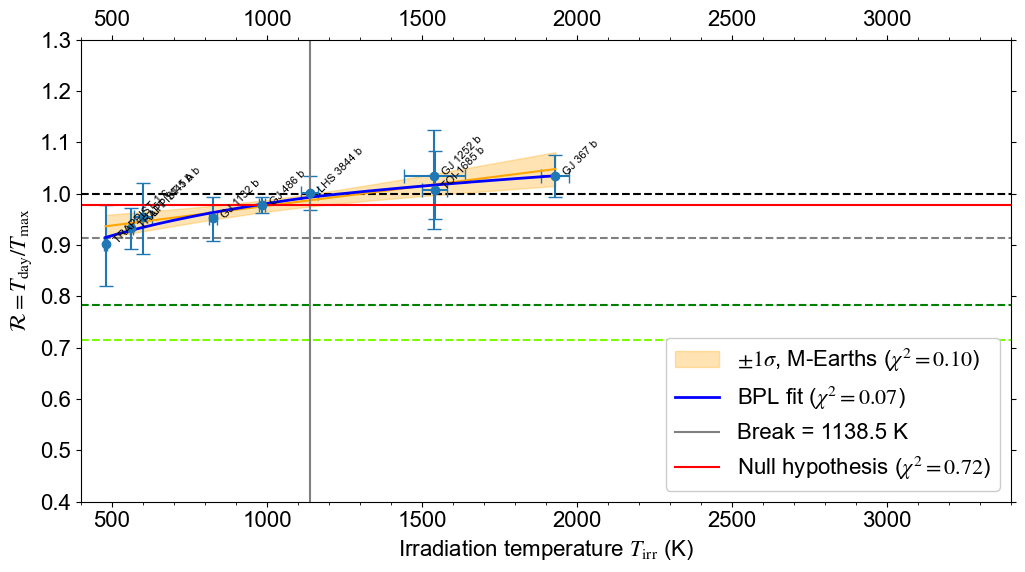

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# plot R under some specific cases: 0 Ab and no redistribution, Earth-like 0.3 Ab, and full redistribution
ax.axhline(1.0, color='k', linestyle='--') #, label=r"$A_B=0$, $\epsilon=0$")
ax.axhline(calcR(0.3, 0), color='#808080', linestyle='--') #, label=r"$A_B=0.3$, $\epsilon=0$")
ax.axhline(calcR(0, 1.0), color='g', linestyle='--') #, label=r"$A_B=0$, $\epsilon=1$")
ax.axhline(calcR(0.3, 1.0), color='#7CFC00', linestyle='--') #, label=r"$A_B=0.3$, $\epsilon=1$")

# plot the measured R of exoplanets
ax.errorbar(data_coy["T0_calculated"], data_coy["R_PHOENIX"], 
            xerr=data_coy["T0_calculated_err"],
            yerr=(-data_coy["R_PHOENIX_err2"], data_coy["R_PHOENIX_err1"]),
            linestyle='', marker="o", capsize=5)

# annotate planet name
for i in range(len(data_coy["pl_name"])):
    ax.annotate(data_coy["pl_name"][i], (data_coy["T0_calculated"][i]+20, data_coy["R_PHOENIX"][i]), 
                rotation=45, fontsize=8)

#======== Code block for fitting ==============================
# fit linear trend
output, slope, intercept, slope_err, intercept_err, p_value = \
    fit_linear_odr(data_coy["T0_calculated"], data_coy["R_PHOENIX"], 
                   data_coy["T0_calculated_err"], 
                   (data_coy["R_PHOENIX_err1"]-data_coy["R_PHOENIX_err2"])/2)

x_fit = np.linspace(min(data_coy["T0_calculated"])-0.5, max(data_coy["T0_calculated"])+0.5, 500)
y_fit = linear_func([slope, intercept], x_fit)
y_fit_err = fit_linear_odr_interval(x_fit, output)

# perform broken power law fits
bpl_res = broken_power_law_odr(data_coy["T0_calculated"], data_coy["R_PHOENIX"],
                               data_coy["T0_calculated_err"],
                               (data_coy["R_PHOENIX_err1"]-data_coy["R_PHOENIX_err2"])/2)

# perform chi2 analysis
chi2_res = compute_reduced_chi2(data_coy["T0_calculated"], data_coy["R_PHOENIX"], 
                                (data_coy["R_PHOENIX_err1"]-data_coy["R_PHOENIX_err2"])/2,
                                linear_model=linear_func,
                                linear_params=[slope, intercept],
                                bpl_model=broken_power_law,
                                bpl_params=bpl_res["beta"])
print(chi2_res)

# plot the fitted linear trend
ax.plot(x_fit, y_fit, color='orange')
ax.fill_between(x_fit, y_fit - y_fit_err, y_fit + y_fit_err, color='orange', alpha=0.3, 
                label=r'$\pm1\sigma$, M-Earths ($\chi^2={%.2f}$)' % chi2_res["linear"]["reduced_chi2"])

# plot broken power law fit
x_fit = np.linspace(min(data_coy["T0_calculated"])-0.5, max(data_coy["T0_calculated"])+0.5, 500)
y_fit = broken_power_law(bpl_res["beta"], x_fit)
ax.plot(x_fit, y_fit, 'b-', lw=2, 
        label='BPL fit ($\chi^2={%.2f}$)' % chi2_res["broken_power_law"]["reduced_chi2"])
ax.axvline(bpl_res['xb'], color='gray', ls='-', label=f"Break = {bpl_res['xb']:.1f} K")
print(bpl_res["beta"])

# plot the null hypothesis
ax.axhline(np.mean(data_coy["R_PHOENIX"]), color="r", 
           label=r"Null hypothesis ($\chi^2={%.2f}$)" % chi2_res["null"]["reduced_chi2"])
print(np.mean(data_coy["R_PHOENIX"]))
#===============================================================

ax.set_xlabel(r"Irradiation temperature $T_{\rm irr}$ (K)", fontsize=16)
ax.set_ylabel(r"$\mathcal{R} = T_{\rm day} / T_{\rm max}$", fontsize=16)
ax.set_xlim([400, 3400])
ax.set_ylim([0.4, 1.3])
ax.xaxis.set_minor_locator(MultipleLocator(100.0))
ax.tick_params(axis='both', which='both', labelsize=16, top=True, right=True, labeltop=True)

plt.legend(fontsize=16, fancybox=True, framealpha=1, loc="lower right")

plt.show()

# (4) Generate Figure 3 for paper
- BPL fit for all planets

- Linear fit for M-Earths

- Null hypothesis is a step function

Caption from the paper: Dayside temperature scaling factor, $\mathcal{R} = T_{\rm day}/T_{\rm day,max}$, as a function of irradiation temperature, $T_{\rm irr}$, for (a) all observed rocky exoplanets and (b) planets with $T_{\rm irr} > 1500$ K, which may have rock vapor atmospheres. Observed exoplanets (Table 1), excluding LHS 1478 b, are shown as black error bars. Two fits are shown: (cyan) linear fit for M-Earths shows a positive trend, while (blue) BPL fit shows a positive trend for M-Earths with $T_{\rm irr} < T_b = 1790$ K and a negative trend for five extremely hot planets with $T_{\rm irr} > T_b$. Both fits are better than the null hypothesis (red line in panel a), suggesting an underlying physical mechanism that produces both thermal emission excess and deficit. In (a), the melting temperatures of silicates (orange and magenta vertical lines) are annotated. In (b), R of exoplanets with rock vapor atmospheres derived from a scaling relation (D. D. B. Koll 2022) are shown in red, green, and orange for surface Bond albedo of 0, 0.3, and 0.5, respectively. Thick atmospheres with $P_s$ much greater than the equilibrium pressure Peq are required to explain the observed thermal deficit.

Linear fit results 9.372068736583426e-05 0.8791114082892632 3.774844361760021e-05 0.03606356895019623 0.02450853720937718
{'null': {'reduced_chi2': 1.9566587716106727, 'dof': 23}, 'linear': {'reduced_chi2': 65.12407165895178, 'dof': 22}, 'broken_power_law': {'reduced_chi2': 1.4201619678975541, 'dof': 20}}
{'null': {'reduced_chi2': 1.5033639182128238, 'dof': 17}, 'linear': {'reduced_chi2': 0.9737848776468657, 'dof': 16}, 'broken_power_law': {'reduced_chi2': None, 'dof': None}}
BPL results 1.033098016577723 1790.2379048649589 -0.09734198280055256 0.7961145258430691 0.031576031866121804 255.50378965124807 0.04276339785468326 0.21949608429103043
null 0.9829444444444445 0.6713333333333334
means 0.9829444444444445 0.6713333333333334


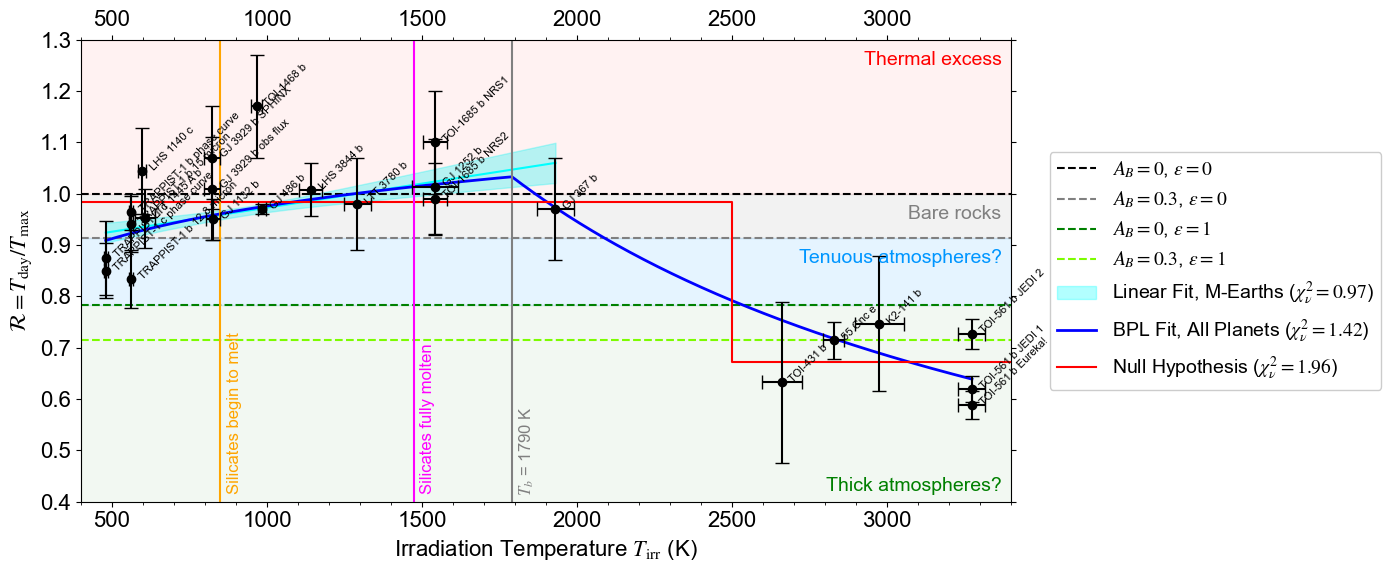

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# plot R under some specific cases: 0 Ab and no redistribution, Earth-like 0.3 Ab, and full redistribution
ax.axhline(1.0, color='k', linestyle='--', label=r"$A_B=0$, $\epsilon=0$")
ax.axhline(calcR(0.3, 0), color='#808080', linestyle='--', label=r"$A_B=0.3$, $\epsilon=0$")
ax.axhline(calcR(0, 1.0), color='g', linestyle='--', label=r"$A_B=0$, $\epsilon=1$")
ax.axhline(calcR(0.3, 1.0), color='#7CFC00', linestyle='--', label=r"$A_B=0.3$, $\epsilon=1$")

# plot the measured R of exoplanets
ax.errorbar(data_allRocky["T0_calculated"], data_allRocky["R_factor"], 
            xerr=data_allRocky["T0_calculated_err"],
            yerr=(-data_allRocky["R_factor_err2"], data_allRocky["R_factor_err1"]),
            linestyle='', marker="o", capsize=5, color="k", zorder=3)

# annotate planet name
for i in range(len(data_allRocky["pl_name"])):
    ax.annotate(data_allRocky["pl_name"][i], (data_allRocky["T0_calculated"][i]+20, data_allRocky["R_factor"][i]), 
                rotation=45, fontsize=8)

#======== Code block for fitting ==============================
# fit linear trend
output, slope, intercept, slope_err, intercept_err, p_value = \
    fit_linear_odr(data_MEarths["T0_calculated"], data_MEarths["R_factor"], 
                   data_MEarths["T0_calculated_err"], 
                   (data_MEarths["R_factor_err1"]-data_MEarths["R_factor_err2"])/2)
print("Linear fit results", slope, intercept, slope_err, intercept_err, p_value)

x_fit = np.linspace(min(data_MEarths["T0_calculated"])-0.5, max(data_MEarths["T0_calculated"])+0.5, 500)
y_fit = linear_func([slope, intercept], x_fit)
y_fit_err = fit_linear_odr_interval(x_fit, output)

# perform broken power law fits
bpl_res = broken_power_law_odr(data_allRocky["T0_calculated"], data_allRocky["R_factor"],
                               data_allRocky["T0_calculated_err"],
                               (data_allRocky["R_factor_err1"]-data_allRocky["R_factor_err2"])/2)

# define null hypothesis model
def null_hypo(tirr):
    return np.where(tirr <= 2500.0, np.mean(data_MEarths["R_factor"]), np.mean(data_KGEarths["R_factor"]))

# perform chi2 analysis
chi2_res = compute_reduced_chi2(data_allRocky["T0_calculated"], data_allRocky["R_factor"], 
                                (data_allRocky["R_factor_err1"]-data_allRocky["R_factor_err2"])/2,
                                linear_model=linear_func,
                                linear_params=[slope, intercept],
                                bpl_model=broken_power_law,
                                bpl_params=bpl_res["beta"], 
                                null_model=null_hypo)
print(chi2_res)

chi2_res_linear = compute_reduced_chi2(data_MEarths["T0_calculated"], data_MEarths["R_factor"], 
                                       (data_MEarths["R_factor_err1"]-data_MEarths["R_factor_err2"])/2,
                                       linear_model=linear_func,
                                       linear_params=[slope, intercept])
print(chi2_res_linear)

# plot the fitted linear trend
ax.plot(x_fit, y_fit, color='cyan')
ax.fill_between(x_fit, y_fit - y_fit_err, y_fit + y_fit_err, color='cyan', alpha=0.3, 
                label=r'Linear Fit, M-Earths ($\chi_\nu^2={%.2f}$)' % chi2_res_linear["linear"]["reduced_chi2"])

# plot broken power law fit
x_fit = np.linspace(min(data_allRocky["T0_calculated"])-0.5, max(data_allRocky["T0_calculated"])+0.5, 500)
y_fit = broken_power_law(bpl_res["beta"], x_fit)
ax.plot(x_fit, y_fit, 'b-', lw=2, 
        label=r'BPL Fit, All Planets ($\chi_\nu^2={%.2f}$)' % chi2_res["broken_power_law"]["reduced_chi2"])
ax.axvline(bpl_res['xb'], color='gray', ls='-') #, label=f"Break Temperature = {bpl_res['xb']:.0f} K")
ax.annotate(r"$T_b$" + f" = {bpl_res['xb']:.0f} K", (bpl_res['xb']+20, 0.42), rotation=90, 
            color="gray", fontsize=12)
print("BPL results", bpl_res["A"], bpl_res["xb"], bpl_res["alpha1"], bpl_res["alpha2"],
      bpl_res["A_err"], bpl_res["xb_err"], bpl_res["alpha1_err"], bpl_res["alpha2_err"])

ax.plot([0, 2500, 2500, 3400],
        [np.mean(data_MEarths["R_factor"]), np.mean(data_MEarths["R_factor"]), 
         np.mean(data_KGEarths["R_factor"]), np.mean(data_KGEarths["R_factor"])],
        label=r"Null Hypothesis ($\chi_\nu^2={%.2f}$)" % chi2_res["null"]["reduced_chi2"],
        color="r")
print("null", np.mean(data_MEarths["R_factor"]), np.mean(data_KGEarths["R_factor"]))
print("means", np.mean(data_MEarths["R_factor"]), np.mean(data_KGEarths["R_factor"]))
#===============================================================

# fill regions where R > 1, compatible with bare rock, and compatible with atmosphere
ax.fill_between([400, 3400], 1.0, 1.3, color="r", alpha=0.05)
ax.fill_between([400, 3400], calcR(0.3, 0), 1.0, color="#808080", alpha=0.1)
ax.fill_between([400, 3400], calcR(0, 1), calcR(0.3, 0), color="#0096FF", alpha=0.1)
ax.fill_between([400, 3400], 0, calcR(0, 1), color="g", alpha=0.05)

# annotate the regions
ax.annotate("Thermal excess", (3370, 1.25), color="r", ha="right", fontsize=14)
ax.annotate("Bare rocks", (3370, 1.0-0.05), color="#808080", ha="right", fontsize=14)
ax.annotate("Tenuous atmospheres?", (3370, calcR(0.3, 0)-0.05), color="#0096FF", ha="right", fontsize=14)
ax.annotate("Thick atmospheres?", (3370, 0.4+0.02), color="g", ha="right", fontsize=14)

# silicate melting temperatures
ax.axvline(850.0, color="orange") #, label="Silicates begin melting")
ax.axvline(1473.0, color="magenta") #, label="All silicates molten")
ax.annotate("Silicates begin to melt", (850.0+20, 0.42), rotation=90, color="orange", fontsize=12)
ax.annotate("Silicates fully molten", (1473.0+20, 0.42), rotation=90, color="magenta", fontsize=12)

ax.set_xlabel(r"Irradiation Temperature $T_{\rm irr}$ (K)", fontsize=16)
ax.set_ylabel(r"$\mathcal{R} = T_{\rm day} / T_{\rm max}$", fontsize=16)
ax.set_xlim([400, 3400])
ax.set_ylim([0.4, 1.3])
ax.xaxis.set_minor_locator(MultipleLocator(100.0))
ax.tick_params(axis='both', which='both', labelsize=16, top=True, right=True, labeltop=True)

plt.legend(fontsize=14, fancybox=True, framealpha=1, loc="center",
           bbox_to_anchor=(1.22, 0.5))

# plt.savefig("RockyPlanetIR_Tirr_vs_R_ODR_BPL_fits.pdf", bbox_inches="tight")
# plt.savefig("RockyPlanetIR_Tirr_vs_R_ODR_BPL_fits.png", bbox_inches="tight", dpi=300)
plt.show()

We are not finished yet - the next section will focus on calculating atmospheric effects on $\epsilon$, which will get us curves shown in Fig. 3b in the paper.

# (5) Cause of the negative trend?
Is it generate by rock vapor atmosphere? Find relation between rock vapor atmosphere pressure, $T_{\rm irr}$, and $\varepsilon$.

See e.g., Ito et al. (2015), which shows the relation between total atmospheric pressure and temperature.

## (5-1) Implement Koll (2022) scaling relation
\begin{equation}
    f = \frac{2}{3} - \frac{5}{12} \times \frac{\tau_{\rm LW}^{1/3}\left(\frac{p_s}{\rm 1\,bar}\right)^{2/3}\left(\frac{T_{\rm eq}}{\rm 600\,K}\right)^{-4/3}}{k + \tau_{\rm LW}^{1/3}\left(\frac{p_s}{\rm 1\,bar}\right)^{2/3}\left(\frac{T_{\rm eq}}{\rm 600\,K}\right)^{-4/3}},
\end{equation}

$k$ and $\tau_{\rm LW}$ can both be assumed to be 1.

Note that this can be simplified as
\begin{equation}
    \varepsilon = \frac{\tau_{\rm LW}^{1/3}\left(\frac{p_s}{\rm 1\,bar}\right)^{2/3}\left(\frac{T_{\rm eq}}{\rm 600\,K}\right)^{-4/3}}{k + \tau_{\rm LW}^{1/3}\left(\frac{p_s}{\rm 1\,bar}\right)^{2/3}\left(\frac{T_{\rm eq}}{\rm 600\,K}\right)^{-4/3}},
\end{equation}

In [30]:
def f_factor_koll22(ps, teq, tauLW=1, k=1):
    """ ps should be given in bar, teq in K. """
    teq_scaled = teq/600.0
    a = tauLW**(1/3) * ps**(2/3) * teq_scaled**(-4/3)
    f = (2/3) - (5/12) * a/(k+a)
    return f


def ep_factor_koll22(ps, teq, tauLW=1, k=1):
    """ ps should be given in bar, teq in K. """
    teq_scaled = teq/600.0
    a = tauLW**(1/3) * ps**(2/3) * teq_scaled**(-4/3)
    ep = a/(k+a)
    return ep

## (5-2) Implement Ito et al. (2015) P-T relation
See their Fig. 1. Their temperature should be $T_{\rm irr}$ (see their Section 4, Eq. 16, where the temperature is defined in the same way as $T_{\rm irr}$).

Fit a 2nd order polynomial to the P-T data, to allow extrapolation beyond 3000 K.

In [31]:
ito15t, ito15p = np.genfromtxt("Ito2015_et_al_P_T.csv", delimiter=",")[:,0], np.genfromtxt("Ito2015_et_al_P_T.csv", delimiter=",")[:,1]

[-4.95612009e-13  5.41030433e-09 -2.27346506e-05  4.62450359e-02
 -4.05935301e+01]


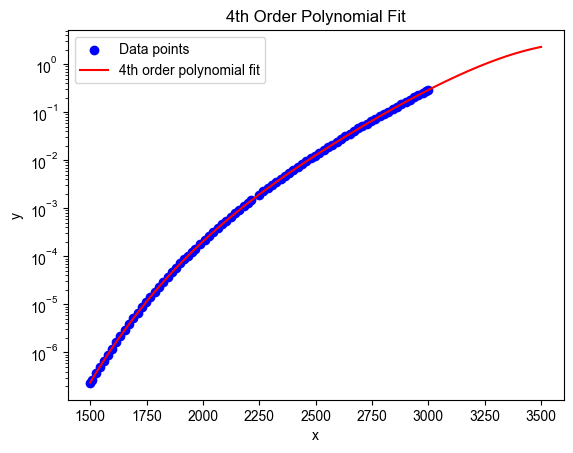

In [32]:
# Fit a 2nd-order polynomial: y = a*x^2 + b*x + c
coeffs = np.polyfit(ito15t, np.log10(ito15p), deg=4)
print(coeffs)

# Generate fitted values
t_fit = np.linspace(1500, 3500, 1000)
p_fit = 10**np.polyval(coeffs, t_fit)

# Plot data and fitted curve
plt.scatter(ito15t, ito15p, color='blue', label='Data points')
plt.plot(t_fit, p_fit, color='red', label='4th order polynomial fit')
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.yscale("log")
plt.title("4th Order Polynomial Fit")
plt.show()

## (5-3) Combined the two functions above, to calculate $\varepsilon$ vs $T_{\rm irr}$
Hence, we can get $\mathcal{R}$ vs $T_{\rm irr}$.

Note that $\frac{2}{3} - \frac{5}{12}\varepsilon = f$, so $(\frac{2}{3} - f)/\frac{5}{12} = \varepsilon$

Note that as defined in Koll (2022), $T_{\rm eq} = (1/\sqrt{2}) T_{\rm irr}$.

In [33]:
tirr_arr = np.linspace(1500, 3500, 1000)
teq_arr = (1/np.sqrt(2)) * tirr_arr

# assuming rock vapor atmosphere in equilibrium
ps_arr = 10**np.polyval(coeffs, tirr_arr)
# print(ps_arr)
# f_arr = f_factor_koll22(ps_arr, teq_arr, k=2)
# ep_arr = ((2/3) - f_arr) / (5/12)
ep_arr = ep_factor_koll22(ps_arr, teq_arr, k=2)
R_arr_ab00 = calcR(0.0, ep_arr)
R_arr_ab01 = calcR(0.1, ep_arr)
R_arr_ab03 = calcR(0.3, ep_arr)
R_arr_ab05 = calcR(0.5, ep_arr)

# assuming rock vapor + outgassed atmosphere (x10 pressure)
ps_arr2 = 10**np.polyval(coeffs, tirr_arr) * 10
# print(ps_arr2)
# f_arr2 = f_factor_koll22(ps_arr2, teq_arr, k=2)
# ep_arr2 = ((2/3) - f_arr2) / (5/12)
ep_arr2 = ep_factor_koll22(ps_arr2, teq_arr, k=2)
R_arr2_ab00 = calcR(0.0, ep_arr2)
R_arr2_ab01 = calcR(0.1, ep_arr2)
R_arr2_ab03 = calcR(0.3, ep_arr2)
R_arr2_ab05 = calcR(0.5, ep_arr2)

# assuming rock vapor + a lot of outgassed atmosphere (x100 pressure)
ps_arr3 = 10**np.polyval(coeffs, tirr_arr) * 100
# f_arr3 = f_factor_koll22(ps_arr3, teq_arr, k=2)
# ep_arr3 = ((2/3) - f_arr3) / (5/12)
ep_arr3 = ep_factor_koll22(ps_arr3, teq_arr, k=2)
R_arr3_ab00 = calcR(0.0, ep_arr3)
R_arr3_ab01 = calcR(0.1, ep_arr3)
R_arr3_ab03 = calcR(0.3, ep_arr3)
R_arr3_ab05 = calcR(0.5, ep_arr3)
# print(R_arr3_ab00)

2.283744033570676 22.83744033570676 228.3744033570676


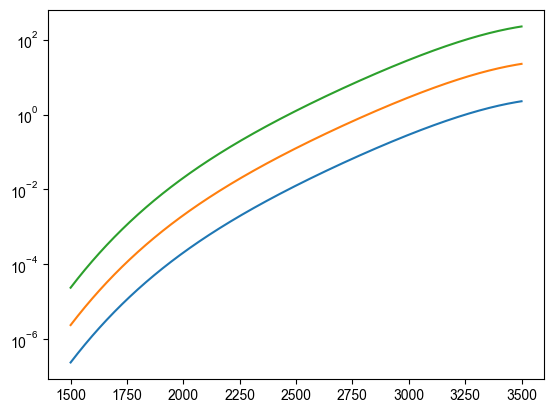

In [34]:
# plot surface pressure as a function of Tirr
plt.plot(tirr_arr, ps_arr)
plt.plot(tirr_arr, ps_arr2)
plt.plot(tirr_arr, ps_arr3)
plt.yscale("log")
print(max(ps_arr), max(ps_arr2), max(ps_arr3))

0.11588832495157703 0.3782695401655313 0.738494257877776


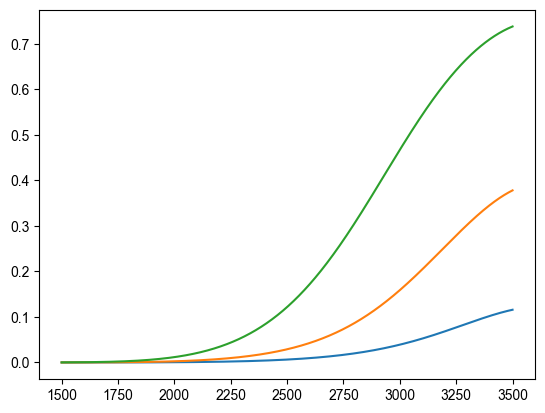

In [35]:
# plot surface pressure as a function of epsilon
plt.plot(tirr_arr, ep_arr)
plt.plot(tirr_arr, ep_arr2)
plt.plot(tirr_arr, ep_arr3)
print(max(ep_arr), max(ep_arr2), max(ep_arr3))

In [36]:
# these are the planets with dayside emission temperature observations
selected_planets = ['55 Cnc e', 'GJ 1132 b', 'GJ 1252 b', 'GJ 367 b', 'GJ 486 b', 'K2-141 b', 
                    'LHS 3844 b', 'LTT 1445 A b', 'TOI-1468 b', 'TOI-1685 b NRS1', 'TOI-1685 b NRS2', 
                    'TOI-431 b', 'LHS 1140 c', 'LTT 3780 b', 'GJ 3929 b SPHINX',
                    'TRAPPIST-1 b phase curve', 'TRAPPIST-1 c phase curve', 'TOI-561 b Eureka!', 
                    'TOI-561 b JEDI 1', 'TOI-561 b JEDI 2']

Linear fit results 9.372068736583426e-05 0.8791114082892632 3.774844361760021e-05 0.03606356895019623 0.02450853720937718
[[ 1.46414523e-09 -1.36161895e-06]
 [-1.36161895e-06  1.33635999e-03]]
X range 480.13 1930.89
X range BPL 480.13 3274.5
{'A': 1.033098016577723, 'xb': 1790.2379048649589, 'alpha1': -0.09734198280055256, 'alpha2': 0.7961145258430691, 'A_err': 0.031576031866121804, 'xb_err': 255.50378965124807, 'alpha1_err': 0.04276339785468326, 'alpha2_err': 0.21949608429103043, 'cov': array([[ 9.97045788e-04,  1.70540149e+00, -1.14308776e-03,
         2.99124760e-03],
       [ 1.70540149e+00,  6.52821865e+04,  2.48813047e+00,
         5.32502145e+01],
       [-1.14308776e-03,  2.48813047e+00,  1.82870820e-03,
        -4.39039166e-10],
       [ 2.99124760e-03,  5.32502145e+01, -4.39039166e-10,
         4.81785310e-02]]), 'res_var': 1.381716645690396, 'beta': array([ 1.03309802e+00,  1.79023790e+03, -9.73419828e-02,  7.96114526e-01]), 'y_model': array([0.71774087, 0.95820573, 1.018164

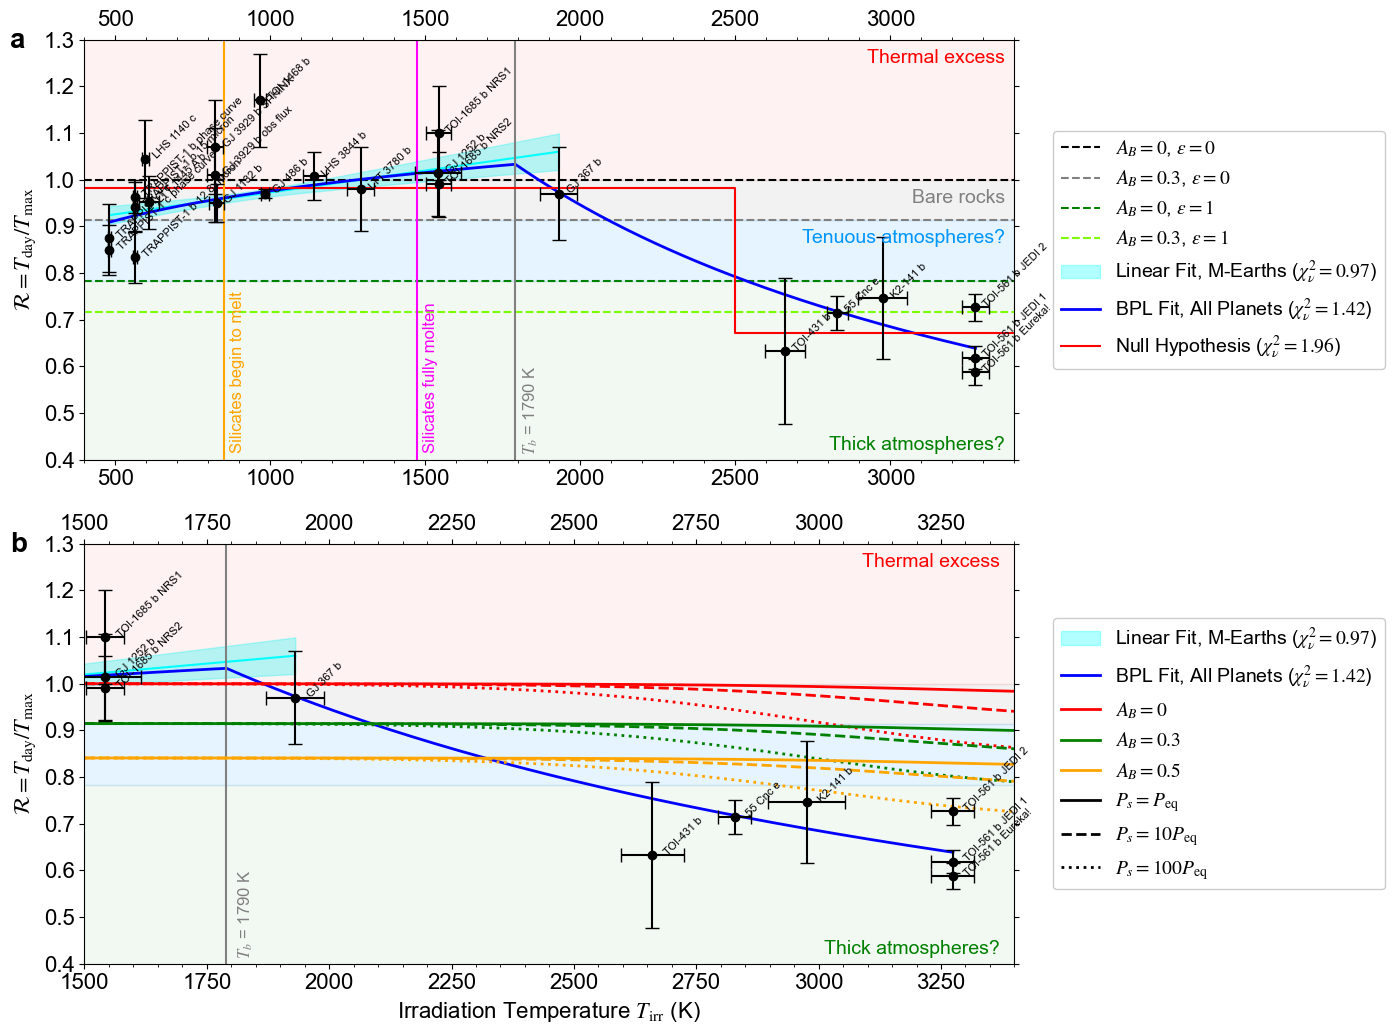

In [37]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

#========================================================================
# plot R under some specific cases: 0 Ab and no redistribution, Earth-like 0.3 Ab, and full redistribution
ax[0].axhline(1.0, color='k', linestyle='--', label=r"$A_B=0$, $\epsilon=0$")
ax[0].axhline(calcR(0.3, 0), color='#808080', linestyle='--', label=r"$A_B=0.3$, $\epsilon=0$")
ax[0].axhline(calcR(0, 1.0), color='g', linestyle='--', label=r"$A_B=0$, $\epsilon=1$")
ax[0].axhline(calcR(0.3, 1.0), color='#7CFC00', linestyle='--', label=r"$A_B=0.3$, $\epsilon=1$")

# plot the measured R of exoplanets
ax[0].errorbar(data_allRocky["T0_calculated"], data_allRocky["R_factor"], 
            xerr=data_allRocky["T0_calculated_err"],
            yerr=(-data_allRocky["R_factor_err2"], data_allRocky["R_factor_err1"]),
            linestyle='', marker="o", capsize=5, color="k", zorder=3)

# annotate planet name
for i in range(len(data_allRocky["pl_name"])):
    ax[0].annotate(data_allRocky["pl_name"][i], (data_allRocky["T0_calculated"][i]+20, data_allRocky["R_factor"][i]), 
                rotation=45, fontsize=8)

#======== Code block for fitting ==============================
# fit linear trend
output, slope, intercept, slope_err, intercept_err, p_value = \
    fit_linear_odr(data_MEarths["T0_calculated"], data_MEarths["R_factor"], 
                   data_MEarths["T0_calculated_err"], 
                   (data_MEarths["R_factor_err1"]-data_MEarths["R_factor_err2"])/2)
print("Linear fit results", slope, intercept, slope_err, intercept_err, p_value)
print(output.cov_beta)

x_fit = np.linspace(min(data_MEarths["T0_calculated"])-0.5, max(data_MEarths["T0_calculated"])+0.5, 500)
y_fit = linear_func([slope, intercept], x_fit)
y_fit_err = fit_linear_odr_interval(x_fit, output)

# perform broken power law fits
bpl_res = broken_power_law_odr(data_allRocky["T0_calculated"], data_allRocky["R_factor"],
                               data_allRocky["T0_calculated_err"],
                               (data_allRocky["R_factor_err1"]-data_allRocky["R_factor_err2"])/2)

# define null hypothesis model
def null_hypo(tirr):
    return np.where(tirr <= 2500.0, np.mean(data_MEarths["R_factor"]), np.mean(data_KGEarths["R_factor"]))

# perform chi2 analysis
chi2_res = compute_reduced_chi2(data_allRocky["T0_calculated"], data_allRocky["R_factor"], 
                                (data_allRocky["R_factor_err1"]-data_allRocky["R_factor_err2"])/2,
                                linear_model=linear_func,
                                linear_params=[slope, intercept],
                                bpl_model=broken_power_law,
                                bpl_params=bpl_res["beta"], 
                                null_model=null_hypo)

chi2_res_linear = compute_reduced_chi2(data_MEarths["T0_calculated"], data_MEarths["R_factor"], 
                                       (data_MEarths["R_factor_err1"]-data_MEarths["R_factor_err2"])/2,
                                       linear_model=linear_func,
                                       linear_params=[slope, intercept])

# plot the fitted linear trend
ax[0].plot(x_fit, y_fit, color='cyan')
ax[0].fill_between(x_fit, y_fit - y_fit_err, y_fit + y_fit_err, color='cyan', alpha=0.3, 
                label=r'Linear Fit, M-Earths ($\chi_\nu^2={%.2f}$)' % chi2_res_linear["linear"]["reduced_chi2"])

# plot broken power law fit
x_fit = np.linspace(min(data_allRocky["T0_calculated"])-0.5, max(data_allRocky["T0_calculated"])+0.5, 500)
y_fit = broken_power_law(bpl_res["beta"], x_fit)
ax[0].plot(x_fit, y_fit, 'b-', lw=2, 
        label=r'BPL Fit, All Planets ($\chi_\nu^2={%.2f}$)' % chi2_res["broken_power_law"]["reduced_chi2"])
ax[0].axvline(bpl_res['xb'], color='gray', ls='-') #, label=f"Break Temperature = {bpl_res['xb']:.0f} K")
ax[0].annotate(r"$T_b$" + f" = {bpl_res['xb']:.0f} K", (bpl_res['xb']+20, 0.42), rotation=90, 
            color="gray", fontsize=12)

ax[0].plot([0, 2500, 2500, 3400],
        [np.mean(data_MEarths["R_factor"]), np.mean(data_MEarths["R_factor"]), 
         np.mean(data_KGEarths["R_factor"]), np.mean(data_KGEarths["R_factor"])],
        label=r"Null Hypothesis ($\chi_\nu^2={%.2f}$)" % chi2_res["null"]["reduced_chi2"],
        color="r")
#===============================================================

# fill regions where R > 1, compatible with bare rock, and compatible with atmosphere
ax[0].fill_between([400, 3400], 1.0, 1.3, color="r", alpha=0.05)
ax[0].fill_between([400, 3400], calcR(0.3, 0), 1.0, color="#808080", alpha=0.1)
ax[0].fill_between([400, 3400], calcR(0, 1), calcR(0.3, 0), color="#0096FF", alpha=0.1)
ax[0].fill_between([400, 3400], 0, calcR(0, 1), color="g", alpha=0.05)

# annotate the regions
ax[0].annotate("Thermal excess", (3370, 1.25), color="r", ha="right", fontsize=14)
ax[0].annotate("Bare rocks", (3370, 1.0-0.05), color="#808080", ha="right", fontsize=14)
ax[0].annotate("Tenuous atmospheres?", (3370, calcR(0.3, 0)-0.05), color="#0096FF", ha="right", fontsize=14)
ax[0].annotate("Thick atmospheres?", (3370, 0.4+0.02), color="g", ha="right", fontsize=14)

# silicate melting temperatures
ax[0].axvline(850.0, color="orange") #, label="Silicates begin melting")
ax[0].axvline(1473.0, color="magenta") #, label="All silicates molten")
ax[0].annotate("Silicates begin to melt", (850.0+20, 0.42), rotation=90, color="orange", fontsize=12)
ax[0].annotate("Silicates fully molten", (1473.0+20, 0.42), rotation=90, color="magenta", fontsize=12)

# ax[0].set_xlabel(r"Irradiation Temperature $T_{\rm irr}$ (K)", fontsize=16)
ax[0].set_ylabel(r"$\mathcal{R} = T_{\rm day} / T_{\rm max}$", fontsize=16)
ax[0].set_xlim([400, 3400])
ax[0].set_ylim([0.4, 1.3])
ax[0].xaxis.set_minor_locator(MultipleLocator(100.0))
ax[0].tick_params(axis='both', which='both', labelsize=16, top=True, right=True, labeltop=True)

ax[0].legend(fontsize=14, fancybox=True, framealpha=1, loc="center",
           bbox_to_anchor=(1.22, 0.5))

#========================================================================
# plot the measured R of exoplanets
ax[1].errorbar(data_allRocky["T0_calculated"], data_allRocky["R_factor"], 
            xerr=data_allRocky["T0_calculated_err"],
            yerr=(-data_allRocky["R_factor_err2"], data_allRocky["R_factor_err1"]),
            linestyle='', marker="o", capsize=5, color="k", zorder=3)

# annotate planet name
for i in range(len(data_allRocky["pl_name"])):
    ax[1].annotate(data_allRocky["pl_name"][i], (data_allRocky["T0_calculated"][i]+20, data_allRocky["R_factor"][i]), 
                rotation=45, fontsize=8)

#======== Code block for fitting ==============================
# fit linear trend
output, slope, intercept, slope_err, intercept_err, p_value = \
    fit_linear_odr(data_MEarths["T0_calculated"], data_MEarths["R_factor"], 
                   data_MEarths["T0_calculated_err"], 
                   (data_MEarths["R_factor_err1"]-data_MEarths["R_factor_err2"])/2)

x_fit = np.linspace(min(data_MEarths["T0_calculated"])-0.5, max(data_MEarths["T0_calculated"])+0.5, 500)
y_fit = linear_func([slope, intercept], x_fit)
y_fit_err = fit_linear_odr_interval(x_fit, output)
print("X range", min(data_MEarths["T0_calculated"])-0.5, max(data_MEarths["T0_calculated"])+0.5)

# perform broken power law fits
bpl_res = broken_power_law_odr(data_allRocky["T0_calculated"], data_allRocky["R_factor"],
                               data_allRocky["T0_calculated_err"],
                               (data_allRocky["R_factor_err1"]-data_allRocky["R_factor_err2"])/2)

# define null hypothesis model
def null_hypo(tirr):
    return np.where(tirr <= 2500.0, np.mean(data_MEarths["R_factor"]), np.mean(data_KGEarths["R_factor"]))

# perform chi2 analysis
chi2_res = compute_reduced_chi2(data_allRocky["T0_calculated"], data_allRocky["R_factor"], 
                                (data_allRocky["R_factor_err1"]-data_allRocky["R_factor_err2"])/2,
                                linear_model=linear_func,
                                linear_params=[slope, intercept],
                                bpl_model=broken_power_law,
                                bpl_params=bpl_res["beta"], 
                                null_model=null_hypo)

chi2_res_linear = compute_reduced_chi2(data_MEarths["T0_calculated"], data_MEarths["R_factor"], 
                                       (data_MEarths["R_factor_err1"]-data_MEarths["R_factor_err2"])/2,
                                       linear_model=linear_func,
                                       linear_params=[slope, intercept])

# plot the fitted linear trend
ax[1].plot(x_fit, y_fit, color='cyan')
ax[1].fill_between(x_fit, y_fit - y_fit_err, y_fit + y_fit_err, color='cyan', alpha=0.3, 
                label=r'Linear Fit, M-Earths ($\chi_\nu^2={%.2f}$)' % chi2_res_linear["linear"]["reduced_chi2"])

# plot broken power law fit
x_fit = np.linspace(min(data_allRocky["T0_calculated"])-0.5, max(data_allRocky["T0_calculated"])+0.5, 500)
y_fit = broken_power_law(bpl_res["beta"], x_fit)
ax[1].plot(x_fit, y_fit, 'b-', lw=2, 
        label=r'BPL Fit, All Planets ($\chi_\nu^2={%.2f}$)' % chi2_res["broken_power_law"]["reduced_chi2"])
ax[1].axvline(bpl_res['xb'], color='gray', ls='-') #, label=f"Break Temperature = {bpl_res['xb']:.0f} K")
ax[1].annotate(r"$T_b$" + f" = {bpl_res['xb']:.0f} K", (bpl_res['xb']+20, 0.42), rotation=90, 
            color="gray", fontsize=12)
print("X range BPL", min(data_allRocky["T0_calculated"])-0.5, max(data_allRocky["T0_calculated"])+0.5)
print(bpl_res)
#===============================================================

# plot the R vs Tirr trends assuming rock vapor atmospheres
ax[1].plot(tirr_arr, R_arr_ab00, lw=2, color="r", linestyle="-", label=r"$A_B=0$")
ax[1].plot(tirr_arr, R_arr2_ab00, lw=2, color="r", linestyle="--")
ax[1].plot(tirr_arr, R_arr3_ab00, lw=2, color="r", linestyle=":")

ax[1].plot(tirr_arr, R_arr_ab03, lw=2, color="g", linestyle="-", label=r"$A_B=0.3$")
ax[1].plot(tirr_arr, R_arr2_ab03, lw=2, color="g", linestyle="--")
ax[1].plot(tirr_arr, R_arr3_ab03, lw=2, color="g", linestyle=":")

ax[1].plot(tirr_arr, R_arr_ab05, lw=2, color="orange", linestyle="-", label=r"$A_B=0.5$")
ax[1].plot(tirr_arr, R_arr2_ab05, lw=2, color="orange", linestyle="--")
ax[1].plot(tirr_arr, R_arr3_ab05, lw=2, color="orange", linestyle=":")

# fill regions where R > 1, compatible with bare rock, and compatible with atmosphere
ax[1].fill_between([400, 3400], 1.0, 1.3, color="r", alpha=0.05)
ax[1].fill_between([400, 3400], calcR(0.3, 0), 1.0, color="#808080", alpha=0.1)
ax[1].fill_between([400, 3400], calcR(0, 1), calcR(0.3, 0), color="#0096FF", alpha=0.1)
ax[1].fill_between([400, 3400], 0, calcR(0, 1), color="g", alpha=0.05)

# fake lines for legends
ax[1].plot([], [], lw=2, color="k", linestyle="-", label=r"$P_s = P_{\rm eq}$")
ax[1].plot([], [], lw=2, color="k", linestyle="--", label=r"$P_s = 10 P_{\rm eq}$")
ax[1].plot([], [], lw=2, color="k", linestyle=":", label=r"$P_s = 100 P_{\rm eq}$")

# # annotate the regions
ax[1].annotate("Thermal excess", (3370, 1.25), color="r", ha="right", fontsize=14)
ax[1].annotate("Thick atmospheres?", (3370, 0.4+0.02), color="g", ha="right", fontsize=14)

ax[1].set_xlabel(r"Irradiation Temperature $T_{\rm irr}$ (K)", fontsize=16)
ax[1].set_ylabel(r"$\mathcal{R} = T_{\rm day} / T_{\rm max}$", fontsize=16)
ax[1].set_xlim([1500, 3400])
ax[1].set_ylim([0.4, 1.3])
ax[1].xaxis.set_minor_locator(MultipleLocator(50.0))
ax[1].tick_params(axis='both', which='both', labelsize=16, top=True, right=True, labeltop=True)

ax[1].legend(fontsize=14, fancybox=True, framealpha=1, loc="center",
           bbox_to_anchor=(1.22, 0.5))

# annotate a, b
ax[0].text(-0.08, 0.98, string.ascii_lowercase[0], transform=ax[0].transAxes, 
           size=20, weight='bold')
ax[1].text(-0.08, 0.98, string.ascii_lowercase[1], transform=ax[1].transAxes, 
           size=20, weight='bold')

# plt.savefig("RockyPlanetIR_Tirr_vs_R_ODR_BPL_fits.pdf", bbox_inches="tight")
# plt.savefig("RockyPlanetIR_Tirr_vs_R_ODR_BPL_fits.png", bbox_inches="tight", dpi=300)
plt.show()

Linear fit results 9.372068736583426e-05 0.8791114082892632 3.774844361760021e-05 0.03606356895019623 0.02450853720937718
[[ 1.46414523e-09 -1.36161895e-06]
 [-1.36161895e-06  1.33635999e-03]]
X range 480.13 1930.89
X range BPL 480.13 3274.5
{'A': 1.033098016577723, 'xb': 1790.2379048649589, 'alpha1': -0.09734198280055256, 'alpha2': 0.7961145258430691, 'A_err': 0.031576031866121804, 'xb_err': 255.50378965124807, 'alpha1_err': 0.04276339785468326, 'alpha2_err': 0.21949608429103043, 'cov': array([[ 9.97045788e-04,  1.70540149e+00, -1.14308776e-03,
         2.99124760e-03],
       [ 1.70540149e+00,  6.52821865e+04,  2.48813047e+00,
         5.32502145e+01],
       [-1.14308776e-03,  2.48813047e+00,  1.82870820e-03,
        -4.39039166e-10],
       [ 2.99124760e-03,  5.32502145e+01, -4.39039166e-10,
         4.81785310e-02]]), 'res_var': 1.381716645690396, 'beta': array([ 1.03309802e+00,  1.79023790e+03, -9.73419828e-02,  7.96114526e-01]), 'y_model': array([0.71774087, 0.95820573, 1.018164

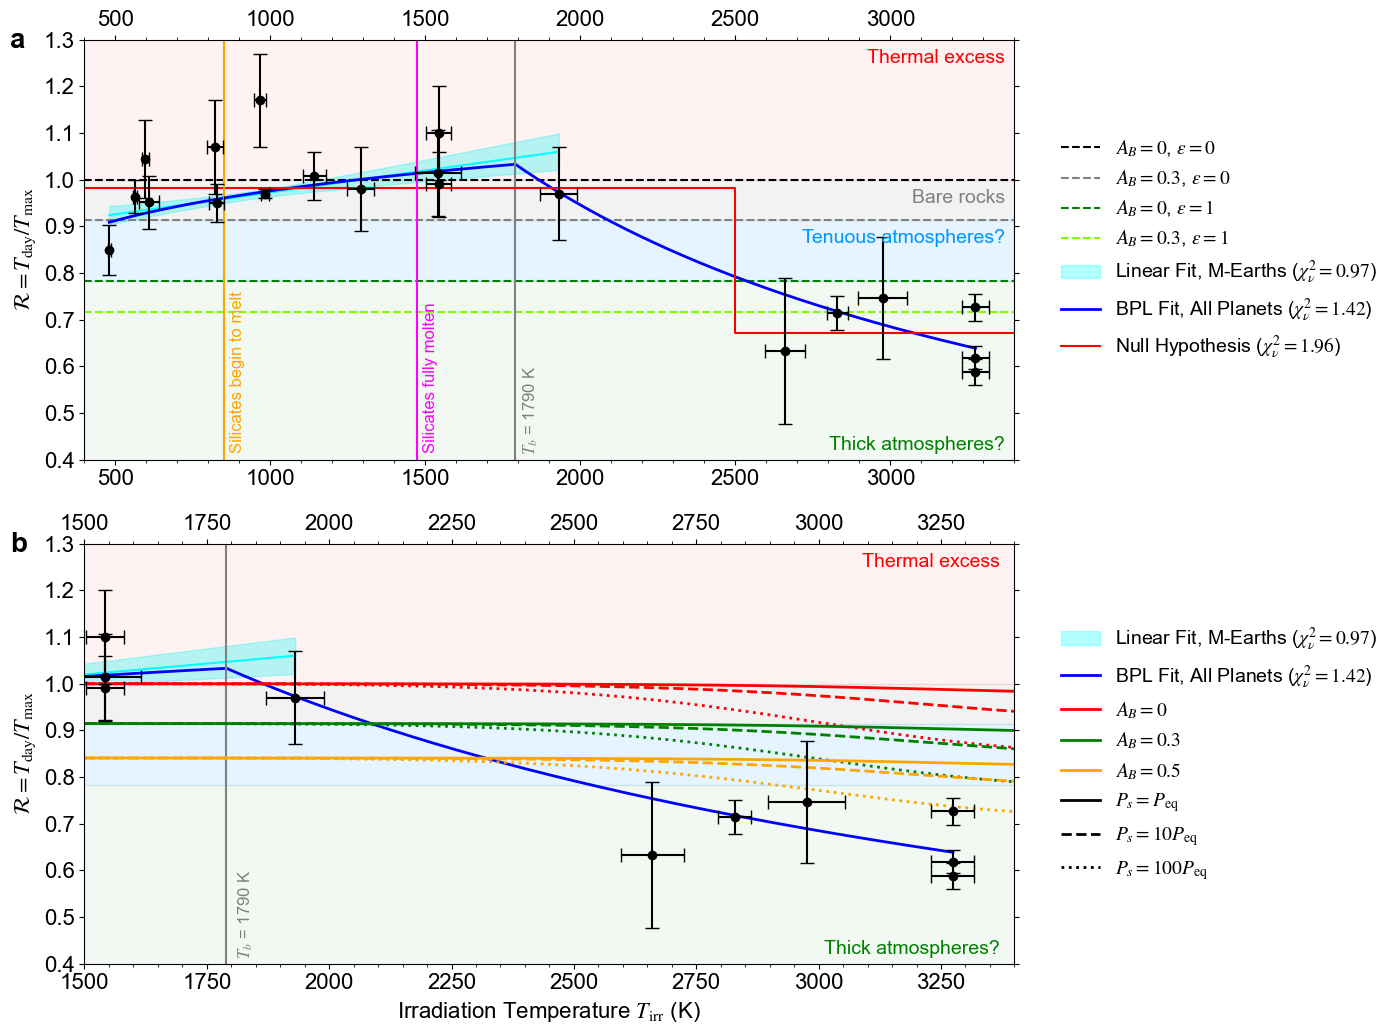

In [38]:
# a slightly different version without planet name annotations
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

#========================================================================
# plot R under some specific cases: 0 Ab and no redistribution, Earth-like 0.3 Ab, and full redistribution
ax[0].axhline(1.0, color='k', linestyle='--', label=r"$A_B=0$, $\epsilon=0$")
ax[0].axhline(calcR(0.3, 0), color='#808080', linestyle='--', label=r"$A_B=0.3$, $\epsilon=0$")
ax[0].axhline(calcR(0, 1.0), color='g', linestyle='--', label=r"$A_B=0$, $\epsilon=1$")
ax[0].axhline(calcR(0.3, 1.0), color='#7CFC00', linestyle='--', label=r"$A_B=0.3$, $\epsilon=1$")

for i in data_allRocky.index.to_list():
    if data_allRocky["pl_name"][i] in selected_planets:
        # plot the measured R of exoplanets
        ax[0].errorbar(data_allRocky["T0_calculated"][i], data_allRocky["R_factor"][i], 
                    xerr=data_allRocky["T0_calculated_err"][i],
                    yerr=[[-data_allRocky["R_factor_err2"][i]], [data_allRocky["R_factor_err1"][i]]],
                    linestyle='', marker="o", capsize=5, color="k", zorder=3)

#======== Code block for fitting ==============================
# fit linear trend
output, slope, intercept, slope_err, intercept_err, p_value = \
    fit_linear_odr(data_MEarths["T0_calculated"], data_MEarths["R_factor"], 
                   data_MEarths["T0_calculated_err"], 
                   (data_MEarths["R_factor_err1"]-data_MEarths["R_factor_err2"])/2)
print("Linear fit results", slope, intercept, slope_err, intercept_err, p_value)
print(output.cov_beta)

x_fit = np.linspace(min(data_MEarths["T0_calculated"])-0.5, max(data_MEarths["T0_calculated"])+0.5, 500)
y_fit = linear_func([slope, intercept], x_fit)
y_fit_err = fit_linear_odr_interval(x_fit, output)

# perform broken power law fits
bpl_res = broken_power_law_odr(data_allRocky["T0_calculated"], data_allRocky["R_factor"],
                               data_allRocky["T0_calculated_err"],
                               (data_allRocky["R_factor_err1"]-data_allRocky["R_factor_err2"])/2)

# define null hypothesis model
def null_hypo(tirr):
    return np.where(tirr <= 2500.0, np.mean(data_MEarths["R_factor"]), np.mean(data_KGEarths["R_factor"]))

# perform chi2 analysis
chi2_res = compute_reduced_chi2(data_allRocky["T0_calculated"], data_allRocky["R_factor"], 
                                (data_allRocky["R_factor_err1"]-data_allRocky["R_factor_err2"])/2,
                                linear_model=linear_func,
                                linear_params=[slope, intercept],
                                bpl_model=broken_power_law,
                                bpl_params=bpl_res["beta"], 
                                null_model=null_hypo)

chi2_res_linear = compute_reduced_chi2(data_MEarths["T0_calculated"], data_MEarths["R_factor"], 
                                       (data_MEarths["R_factor_err1"]-data_MEarths["R_factor_err2"])/2,
                                       linear_model=linear_func,
                                       linear_params=[slope, intercept])

# plot the fitted linear trend
ax[0].plot(x_fit, y_fit, color='cyan')
ax[0].fill_between(x_fit, y_fit - y_fit_err, y_fit + y_fit_err, color='cyan', alpha=0.3, 
                label=r'Linear Fit, M-Earths ($\chi_\nu^2={%.2f}$)' % chi2_res_linear["linear"]["reduced_chi2"])

# plot broken power law fit
x_fit = np.linspace(min(data_allRocky["T0_calculated"])-0.5, max(data_allRocky["T0_calculated"])+0.5, 500)
y_fit = broken_power_law(bpl_res["beta"], x_fit)
ax[0].plot(x_fit, y_fit, 'b-', lw=2, 
        label=r'BPL Fit, All Planets ($\chi_\nu^2={%.2f}$)' % chi2_res["broken_power_law"]["reduced_chi2"])
ax[0].axvline(bpl_res['xb'], color='gray', ls='-') #, label=f"Break Temperature = {bpl_res['xb']:.0f} K")
ax[0].annotate(r"$T_b$" + f" = {bpl_res['xb']:.0f} K", (bpl_res['xb']+20, 0.42), rotation=90, 
            color="gray", fontsize=12)

ax[0].plot([0, 2500, 2500, 3400],
        [np.mean(data_MEarths["R_factor"]), np.mean(data_MEarths["R_factor"]), 
         np.mean(data_KGEarths["R_factor"]), np.mean(data_KGEarths["R_factor"])],
        label=r"Null Hypothesis ($\chi_\nu^2={%.2f}$)" % chi2_res["null"]["reduced_chi2"],
        color="r")
#===============================================================

# fill regions where R > 1, compatible with bare rock, and compatible with atmosphere
ax[0].fill_between([400, 3400], 1.0, 1.3, color="r", alpha=0.05)
ax[0].fill_between([400, 3400], calcR(0.3, 0), 1.0, color="#808080", alpha=0.1)
ax[0].fill_between([400, 3400], calcR(0, 1), calcR(0.3, 0), color="#0096FF", alpha=0.1)
ax[0].fill_between([400, 3400], 0, calcR(0, 1), color="g", alpha=0.05)

# annotate the regions
ax[0].annotate("Thermal excess", (3370, 1.25), color="r", ha="right", fontsize=14)
ax[0].annotate("Bare rocks", (3370, 1.0-0.05), color="#808080", ha="right", fontsize=14)
ax[0].annotate("Tenuous atmospheres?", (3370, calcR(0.3, 0)-0.05), color="#0096FF", ha="right", fontsize=14)
ax[0].annotate("Thick atmospheres?", (3370, 0.4+0.02), color="g", ha="right", fontsize=14)

# silicate melting temperatures
ax[0].axvline(850.0, color="orange") #, label="Silicates begin melting")
ax[0].axvline(1473.0, color="magenta") #, label="All silicates molten")
ax[0].annotate("Silicates begin to melt", (850.0+20, 0.42), rotation=90, color="orange", fontsize=12)
ax[0].annotate("Silicates fully molten", (1473.0+20, 0.42), rotation=90, color="magenta", fontsize=12)

ax[0].set_ylabel(r"$\mathcal{R} = T_{\rm day} / T_{\rm max}$", fontsize=16)
ax[0].set_xlim([400, 3400])
ax[0].set_ylim([0.4, 1.3])
ax[0].xaxis.set_minor_locator(MultipleLocator(100.0))
ax[0].tick_params(axis='both', which='both', labelsize=16, top=True, right=True, labeltop=True)

ax[0].legend(fontsize=14, fancybox=True, framealpha=0, loc="center",
           bbox_to_anchor=(1.22, 0.5))

#========================================================================
# plot the measured R of exoplanets
ax[1].errorbar(data_allRocky["T0_calculated"], data_allRocky["R_factor"], 
            xerr=data_allRocky["T0_calculated_err"],
            yerr=(-data_allRocky["R_factor_err2"], data_allRocky["R_factor_err1"]),
            linestyle='', marker="o", capsize=5, color="k", zorder=3)

#======== Code block for fitting ==============================
# fit linear trend
output, slope, intercept, slope_err, intercept_err, p_value = \
    fit_linear_odr(data_MEarths["T0_calculated"], data_MEarths["R_factor"], 
                   data_MEarths["T0_calculated_err"], 
                   (data_MEarths["R_factor_err1"]-data_MEarths["R_factor_err2"])/2)

x_fit = np.linspace(min(data_MEarths["T0_calculated"])-0.5, max(data_MEarths["T0_calculated"])+0.5, 500)
y_fit = linear_func([slope, intercept], x_fit)
y_fit_err = fit_linear_odr_interval(x_fit, output)
print("X range", min(data_MEarths["T0_calculated"])-0.5, max(data_MEarths["T0_calculated"])+0.5)

# perform broken power law fits
bpl_res = broken_power_law_odr(data_allRocky["T0_calculated"], data_allRocky["R_factor"],
                               data_allRocky["T0_calculated_err"],
                               (data_allRocky["R_factor_err1"]-data_allRocky["R_factor_err2"])/2)

# define null hypothesis model
def null_hypo(tirr):
    return np.where(tirr <= 2500.0, np.mean(data_MEarths["R_factor"]), np.mean(data_KGEarths["R_factor"]))

# perform chi2 analysis
chi2_res = compute_reduced_chi2(data_allRocky["T0_calculated"], data_allRocky["R_factor"], 
                                (data_allRocky["R_factor_err1"]-data_allRocky["R_factor_err2"])/2,
                                linear_model=linear_func,
                                linear_params=[slope, intercept],
                                bpl_model=broken_power_law,
                                bpl_params=bpl_res["beta"], 
                                null_model=null_hypo)

chi2_res_linear = compute_reduced_chi2(data_MEarths["T0_calculated"], data_MEarths["R_factor"], 
                                       (data_MEarths["R_factor_err1"]-data_MEarths["R_factor_err2"])/2,
                                       linear_model=linear_func,
                                       linear_params=[slope, intercept])

# plot the fitted linear trend
ax[1].plot(x_fit, y_fit, color='cyan')
ax[1].fill_between(x_fit, y_fit - y_fit_err, y_fit + y_fit_err, color='cyan', alpha=0.3, 
                label=r'Linear Fit, M-Earths ($\chi_\nu^2={%.2f}$)' % chi2_res_linear["linear"]["reduced_chi2"])

# plot broken power law fit
x_fit = np.linspace(min(data_allRocky["T0_calculated"])-0.5, max(data_allRocky["T0_calculated"])+0.5, 500)
y_fit = broken_power_law(bpl_res["beta"], x_fit)
ax[1].plot(x_fit, y_fit, 'b-', lw=2, 
        label=r'BPL Fit, All Planets ($\chi_\nu^2={%.2f}$)' % chi2_res["broken_power_law"]["reduced_chi2"])
ax[1].axvline(bpl_res['xb'], color='gray', ls='-') #, label=f"Break Temperature = {bpl_res['xb']:.0f} K")
ax[1].annotate(r"$T_b$" + f" = {bpl_res['xb']:.0f} K", (bpl_res['xb']+20, 0.42), rotation=90, 
            color="gray", fontsize=12)
print("X range BPL", min(data_allRocky["T0_calculated"])-0.5, max(data_allRocky["T0_calculated"])+0.5)
print(bpl_res)
#===============================================================

# plot the R vs Tirr trends assuming rock vapor atmospheres
ax[1].plot(tirr_arr, R_arr_ab00, lw=2, color="r", linestyle="-", label=r"$A_B=0$")
ax[1].plot(tirr_arr, R_arr2_ab00, lw=2, color="r", linestyle="--")
ax[1].plot(tirr_arr, R_arr3_ab00, lw=2, color="r", linestyle=":")

ax[1].plot(tirr_arr, R_arr_ab03, lw=2, color="g", linestyle="-", label=r"$A_B=0.3$")
ax[1].plot(tirr_arr, R_arr2_ab03, lw=2, color="g", linestyle="--")
ax[1].plot(tirr_arr, R_arr3_ab03, lw=2, color="g", linestyle=":")

ax[1].plot(tirr_arr, R_arr_ab05, lw=2, color="orange", linestyle="-", label=r"$A_B=0.5$")
ax[1].plot(tirr_arr, R_arr2_ab05, lw=2, color="orange", linestyle="--")
ax[1].plot(tirr_arr, R_arr3_ab05, lw=2, color="orange", linestyle=":")

# fill regions where R > 1, compatible with bare rock, and compatible with atmosphere
ax[1].fill_between([400, 3400], 1.0, 1.3, color="r", alpha=0.05)
ax[1].fill_between([400, 3400], calcR(0.3, 0), 1.0, color="#808080", alpha=0.1)
ax[1].fill_between([400, 3400], calcR(0, 1), calcR(0.3, 0), color="#0096FF", alpha=0.1)
ax[1].fill_between([400, 3400], 0, calcR(0, 1), color="g", alpha=0.05)

# fake lines for legends
ax[1].plot([], [], lw=2, color="k", linestyle="-", label=r"$P_s = P_{\rm eq}$")
ax[1].plot([], [], lw=2, color="k", linestyle="--", label=r"$P_s = 10 P_{\rm eq}$")
ax[1].plot([], [], lw=2, color="k", linestyle=":", label=r"$P_s = 100 P_{\rm eq}$")

# # annotate the regions
ax[1].annotate("Thermal excess", (3370, 1.25), color="r", ha="right", fontsize=14)
ax[1].annotate("Thick atmospheres?", (3370, 0.4+0.02), color="g", ha="right", fontsize=14)

ax[1].set_xlabel(r"Irradiation Temperature $T_{\rm irr}$ (K)", fontsize=16)
ax[1].set_ylabel(r"$\mathcal{R} = T_{\rm day} / T_{\rm max}$", fontsize=16)
ax[1].set_xlim([1500, 3400])
ax[1].set_ylim([0.4, 1.3])
ax[1].xaxis.set_minor_locator(MultipleLocator(50.0))
ax[1].tick_params(axis='both', which='both', labelsize=16, top=True, right=True, labeltop=True)

ax[1].legend(fontsize=14, fancybox=True, framealpha=0, loc="center",
           bbox_to_anchor=(1.22, 0.5))

# annotate a, b
ax[0].text(-0.08, 0.98, string.ascii_lowercase[0], transform=ax[0].transAxes, 
           size=20, weight='bold')
ax[1].text(-0.08, 0.98, string.ascii_lowercase[1], transform=ax[1].transAxes, 
           size=20, weight='bold')

# plt.savefig("RockyPlanetIR_Tirr_vs_R_ODR_BPL_fits_forPosterNA.pdf", bbox_inches="tight")
# plt.savefig("RockyPlanetIR_Tirr_vs_R_ODR_BPL_fits_forPosterNA.png", bbox_inches="tight", dpi=300)
plt.show()

# (6) Leave-one-out (LOO) test
Remove one planet at a time and refit the trend, see how robust the trend is and sensitivity on each planet.

## (6-1) Define functions to perform LOO calculation

In [39]:
# sort data_MEarths and data_allRocky by Tirr
data_MEarths = data_MEarths.sort_values(by="T0_calculated", ascending=True)
data_allRocky = data_allRocky.sort_values(by="T0_calculated", ascending=True)

In [40]:
# check the fit results from above
print(slope, intercept, bpl_res)

9.372068736583426e-05 0.8791114082892632 {'A': 1.033098016577723, 'xb': 1790.2379048649589, 'alpha1': -0.09734198280055256, 'alpha2': 0.7961145258430691, 'A_err': 0.031576031866121804, 'xb_err': 255.50378965124807, 'alpha1_err': 0.04276339785468326, 'alpha2_err': 0.21949608429103043, 'cov': array([[ 9.97045788e-04,  1.70540149e+00, -1.14308776e-03,
         2.99124760e-03],
       [ 1.70540149e+00,  6.52821865e+04,  2.48813047e+00,
         5.32502145e+01],
       [-1.14308776e-03,  2.48813047e+00,  1.82870820e-03,
        -4.39039166e-10],
       [ 2.99124760e-03,  5.32502145e+01, -4.39039166e-10,
         4.81785310e-02]]), 'res_var': 1.381716645690396, 'beta': array([ 1.03309802e+00,  1.79023790e+03, -9.73419828e-02,  7.96114526e-01]), 'y_model': array([0.71774087, 0.95820573, 1.01816471, 0.97292927, 0.97462464,
       0.68939459, 0.98879954, 0.92992769, 0.97293922, 1.01822063,
       1.01822063, 0.75372602, 0.92297695, 0.92297695, 0.90896997,
       0.92836126, 1.00076234, 0.957753

In [41]:
# Arrays to store LOO results
N_linear = len(data_MEarths["T0_calculated"])
N_bpl = len(data_allRocky["T0_calculated"])

p_lin_loo = np.zeros((N_linear, 2))          # slope, intercept
p_bpl_loo = np.zeros((N_bpl, 4))          # A, xb, alpha1, alpha2

In [42]:
# Full-data fits
_, slope_full, intercept_full, _, _, _ = \
    fit_linear_odr(data_MEarths["T0_calculated"], data_MEarths["R_factor"], 
                   data_MEarths["T0_calculated_err"], 
                   (data_MEarths["R_factor_err1"]-data_MEarths["R_factor_err2"])/2)
p_lin_full = slope_full, intercept_full

bpl_res_full = broken_power_law_odr(data_allRocky["T0_calculated"], data_allRocky["R_factor"],
                                    data_allRocky["T0_calculated_err"],
                                    (data_allRocky["R_factor_err1"]-data_allRocky["R_factor_err2"])/2)
p_bpl_full = bpl_res_full["A"], bpl_res_full["xb"], bpl_res_full["alpha1"], bpl_res_full["alpha2"]

In [43]:
# LOO loop for linear fit
for i in range(N_linear):
    mask = np.ones(N_linear, dtype=bool)
    mask[i] = False
    
    x_sub = data_MEarths["T0_calculated"][mask]
    y_sub = data_MEarths["R_factor"][mask]
    xerr_sub = data_MEarths["T0_calculated_err"][mask]
    yerr_sub = (data_MEarths["R_factor_err1"][mask]-data_MEarths["R_factor_err2"][mask])/2
    
    # Linear fit on subset
    _, slope, intercept, _, _, _ = fit_linear_odr(x_sub, y_sub, xerr_sub, yerr_sub)
    p_lin_loo[i] = slope, intercept

delta_lin = p_lin_loo - p_lin_full  # shape (N, 2)
print("Full linear fit:", p_lin_full)
print("LOO shifts (linear):\n", delta_lin)
# print("LOO shifts (linear):\n", p_lin_loo)

Full linear fit: (9.372084322888319e-05, 0.8791112632213607)
LOO shifts (linear):
 [[-1.91667406e-05  1.98571680e-02]
 [-6.72812707e-06  6.97079557e-03]
 [ 1.87092820e-06 -1.98272904e-03]
 [-1.83921352e-05  1.94877677e-02]
 [ 1.81573484e-05 -1.92458416e-02]
 [ 7.87137957e-06 -8.44934227e-03]
 [ 2.48461445e-06 -2.67881412e-03]
 [ 8.53884558e-07 -1.17431955e-03]
 [ 1.79957229e-06 -2.47782144e-03]
 [-6.57319159e-07  9.13743726e-04]
 [-1.10165043e-06 -3.88905902e-04]
 [ 3.85590950e-06 -1.62159122e-04]
 [-2.76098609e-06  1.94718451e-03]
 [ 1.35917376e-06 -1.08409251e-03]
 [ 1.08959434e-06 -9.28024017e-04]
 [-7.31705394e-06  6.23560310e-03]
 [ 7.04466681e-06 -5.99944036e-03]
 [ 1.55220790e-05 -1.36847612e-02]]


In [44]:
# LOO loop for BPL fit
for i in range(N_bpl):
    mask = np.ones(N_bpl, dtype=bool)
    mask[i] = False
    
    x_sub = data_allRocky["T0_calculated"][mask]
    y_sub = data_allRocky["R_factor"][mask]
    xerr_sub = data_allRocky["T0_calculated_err"][mask]
    yerr_sub = (data_allRocky["R_factor_err1"][mask]-data_allRocky["R_factor_err2"][mask])/2
    
    # BPL fit on subset
    bpl_res_loo = broken_power_law_odr(x_sub, y_sub, xerr_sub, yerr_sub)
    p_bpl_loo[i] = bpl_res_loo["A"], bpl_res_loo["xb"], bpl_res_loo["alpha1"], bpl_res_loo["alpha2"]
    
delta_bpl = p_bpl_loo - p_bpl_full  # shape (N, 4)
print("Full BPL fit:", p_bpl_full)
print("LOO shifts (BPL):\n", delta_bpl)

Full BPL fit: (1.0330980011287354, 1790.2378195330498, -0.09734196651327139, 0.7961144366646704)
LOO shifts (BPL):
 [[-1.03300327e-02  2.27414248e+01  1.87090231e-02 -8.60261793e-08]
 [-3.02536739e-03  6.60854160e+00  5.54646890e-03  1.17507029e-06]
 [ 1.33634755e-02 -2.86626405e+01 -2.65554954e-02  5.28873522e-06]
 [-9.65392559e-03  2.12379820e+01  1.84138339e-02  5.92536090e-07]
 [ 2.08445055e-03 -4.52532644e+00 -4.05837215e-03  1.21870322e-06]
 [ 4.37882953e-03 -9.48505859e+00 -8.83372253e-03  6.82271475e-07]
 [ 1.76607668e-03 -3.84768654e+00 -3.58949648e-03 -8.60555207e-06]
 [ 5.73580410e-05 -1.34336128e-01 -6.53683109e-04 -7.49599848e-06]
 [ 1.19910114e-04 -2.59940557e-01 -1.39801115e-03  8.16395833e-07]
 [-4.18109244e-05  8.53728377e-02  6.39345662e-04 -4.42823811e-06]
 [-2.36523886e-03  5.16301887e+00  1.62844438e-03  1.05975244e-06]
 [ 2.72721830e-02 -5.76477332e+01 -2.12979731e-02 -2.71930083e-06]
 [-2.00110017e-03  4.36082218e+00  2.33765772e-03 -3.56333022e-06]
 [ 9.53827649

/var/folders/h8/2tn1p2r14rg6pbtn7hz_k4dw0000gn/T/ipykernel_43003/1200247897.py:4: RuntimeWarning: invalid value encountered in power
  return np.where(x <= xb, A * (x / xb)**(-a1), A * (x / xb)**(-a2))


In [45]:
# edit planet names for plotting
pl_names_MEarths = ['T-1 c (PC)', 'T-1 c (F1500W)', 'T-1 b (F1500W)', 
                    'T-1 b (F1280W)', 'T-1 b (PC)', 'LHS 1140 c', 
                    'LTT 1445 A b', 'GJ 3929 b (MIRI)', 'GJ 3929 b (SPHINX)', 'GJ 1132 b', 
                    'TOI-1468 b', 'GJ 486 b', 'LHS 3844 b', 'LTT 3780 b', 'GJ 1252 b', 
                    'TOI-1685 b (NRS1)', 'TOI-1685 b (NRS2)', 'GJ 367 b']

pl_names_allRocky = ['T-1 c (PC)', 'T-1 c (F1500W)', 'T-1 b (F1500W)', 
                    'T-1 b (F1280W)', 'T-1 b (PC)', 'LHS 1140 c', 
                    'LTT 1445 A b', 'GJ 3929 b (MIRI)', 'GJ 3929 b (SPHINX)', 'GJ 1132 b', 
                    'TOI-1468 b', 'GJ 486 b', 'LHS 3844 b', 'LTT 3780 b', 'GJ 1252 b', 
                    'TOI-1685 b (NRS1)', 'TOI-1685 b (NRS2)', 'GJ 367 b', 'TOI-431 b', '55 Cnc e', 
                     'K2-141 b', 'TOI-561 b (Eureka!)', 'TOI-561 b (JEDI 1)', 'TOI-561 b (JEDI 2)']

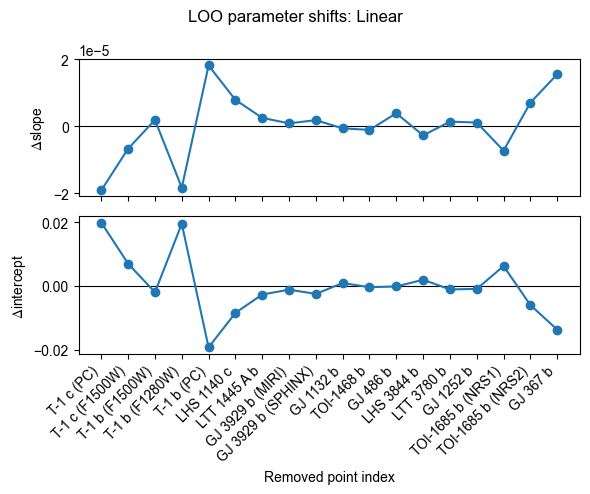

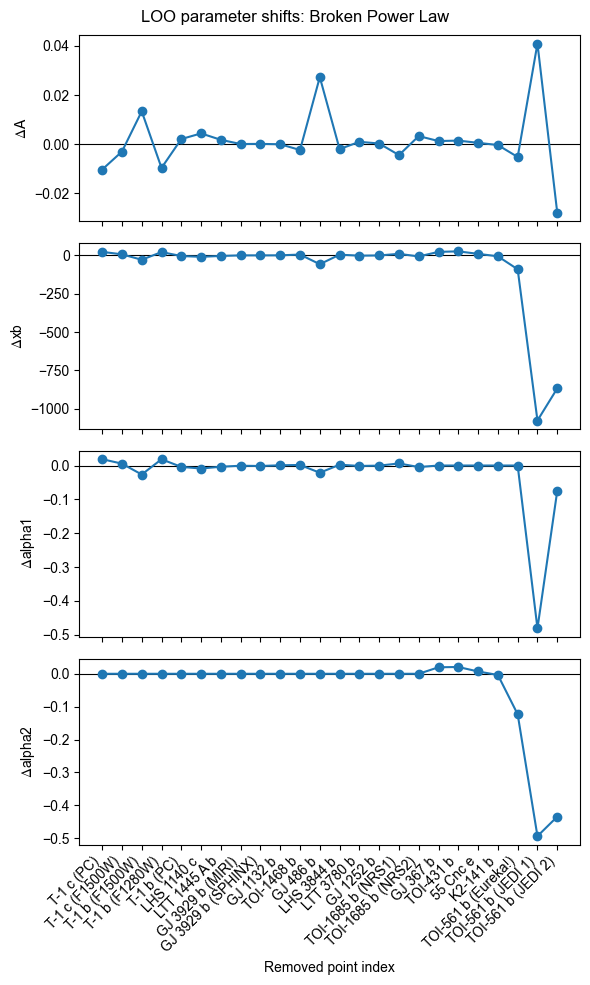

In [46]:
# test plotting: sensitivity of fit parameters on each planet
def plot_param_shifts(name, p_full, p_loo, labels, pl_names):
    N = p_loo.shape[0]
    npar = len(p_full)
    fig, ax = plt.subplots(npar, 1, figsize=(6, 2.5*npar), sharex=True)
    
    for j in range(npar):
        axi = ax[j]
        axi.axhline(0, color='k', lw=0.8)
        axi.plot(pl_names, p_loo[:, j] - p_full[j], marker='o')
        axi.set_ylabel(f"$\Delta${labels[j]}")
    ax[-1].set_xlabel("Removed point index")
    fig.suptitle(f"LOO parameter shifts: {name}")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


# test the plotting function
plot_param_shifts(
    name="Linear",
    p_full=p_lin_full,
    p_loo=p_lin_loo,
    labels=["slope", "intercept"],
    pl_names=pl_names_MEarths
)

plot_param_shifts(
    name="Broken Power Law",
    p_full=p_bpl_full,
    p_loo=p_bpl_loo,
    labels=["A", "xb", "alpha1", "alpha2"],
    pl_names=pl_names_allRocky
)

## (6-2) Generate figure for paper

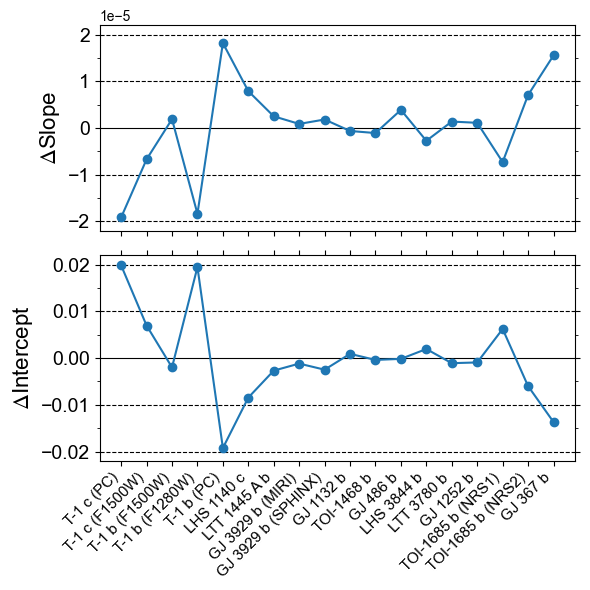

In [47]:
name="Linear"
p_full=p_lin_full
p_loo=p_lin_loo
labels=["Slope", "Intercept"]
pl_names=pl_names_MEarths

N = p_loo.shape[0]
npar = len(p_full)
    
fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

for j in range(npar):
    axi = ax[j]
    axi.axhline(0, color='k', lw=0.8)
    axi.plot(pl_names, p_loo[:, j] - p_full[j], marker='o', zorder=3)
    axi.set_ylabel(f"$\Delta${labels[j]}", fontsize=16)
    
# horizontal lines to make it look nicer
ax[0].axhline(1e-5, color='k', linestyle="--", lw=0.8)
ax[0].axhline(-1e-5, color='k', linestyle="--", lw=0.8)
ax[0].axhline(2e-5, color='k', linestyle="--", lw=0.8)
ax[0].axhline(-2e-5, color='k', linestyle="--", lw=0.8)
ax[1].axhline(1e-2, color='k', linestyle="--", lw=0.8)
ax[1].axhline(-1e-2, color='k', linestyle="--", lw=0.8)
ax[1].axhline(2e-2, color='k', linestyle="--", lw=0.8)
ax[1].axhline(-2e-2, color='k', linestyle="--", lw=0.8)

ax[0].set_ylim([-2.2e-5, 2.2e-5])
ax[0].yaxis.set_minor_locator(MultipleLocator(0.5e-5))
ax[1].set_ylim([-2.2e-2, 2.2e-2])
ax[1].yaxis.set_minor_locator(MultipleLocator(0.5e-2))

ax[0].tick_params(axis='both', which='both', labelsize=14, top=False, right=True, labeltop=False)
ax[1].tick_params(axis='y', which='both', labelsize=14, top=False, right=True, labeltop=False)
ax[1].tick_params(axis='x', which='both', labelsize=11, top=True, right=True, labeltop=False)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# plt.savefig("LOO_results_linear.pdf", bbox_inches="tight")
# plt.savefig("LOO_results_linear.png", bbox_inches="tight", dpi=300)
plt.show()

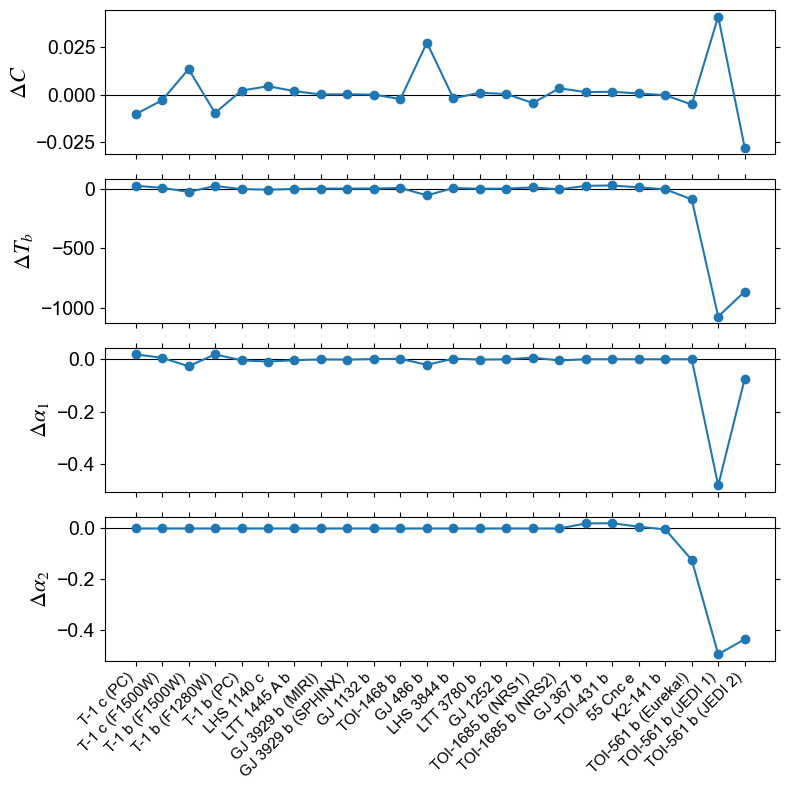

In [48]:
name="Broken Power Law"
p_full=p_bpl_full
p_loo=p_bpl_loo
labels=[r"$C$", r"$T_b$", r"$\alpha_1$", r"$\alpha_2$"]
pl_names=pl_names_allRocky

N = p_loo.shape[0]
npar = len(p_full)
    
fig, ax = plt.subplots(4, 1, figsize=(8, 8), sharex=True)

# plot the change in each parameter
for j in range(npar):
    axi = ax[j]
    axi.axhline(0, color='k', lw=0.8)
    axi.plot(pl_names, p_loo[:, j] - p_full[j], marker='o', zorder=3)
    axi.set_ylabel(f"$\Delta${labels[j]}", fontsize=16)

ax[0].tick_params(axis='both', which='both', labelsize=14, top=False, right=True, labeltop=False)
ax[1].tick_params(axis='both', which='both', labelsize=14, top=True, right=True, labeltop=False)
ax[2].tick_params(axis='both', which='both', labelsize=14, top=True, right=True, labeltop=False)
ax[3].tick_params(axis='y', which='both', labelsize=14, top=False, right=True, labeltop=False)
ax[3].tick_params(axis='x', which='both', labelsize=11, top=True, right=True, labeltop=False)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# plt.savefig("LOO_results_BPL.pdf", bbox_inches="tight")
# plt.savefig("LOO_results_BPL.png", bbox_inches="tight", dpi=300)
plt.show()